In [316]:
import cv2
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
import tensorflow as tf
from tensorflow.keras import layers
keras = tf.keras
AUTOTUNE = tf.data.experimental.AUTOTUNE
from keras.callbacks import TensorBoard
from livelossplot.keras import PlotLossesCallback

from sklearn.model_selection import train_test_split

import datetime
from src.cnn_gender import get_and_clean_data

ModuleNotFoundError: No module named 'livelossplot'

In [2]:
#matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
    'sans-serif' : 'Georgia'}
        #'weight' : 'bold'}
# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice!)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10})
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (16,8)

S = 15
M = 18
B = 28

lw =5

plt.rc('font', size      = S)          # controls default text sizes
plt.rc('axes', titlesize = B)     # fontsize of the axes title
plt.rc('axes', labelsize = M)    # fontsize of the x and y labels
plt.rc('xtick', labelsize= S)    # fontsize of the tick labels
plt.rc('ytick', labelsize= S)    # fontsize of the tick labels
plt.rc('legend', fontsize= M)    # legend fontsize
plt.rc('figure', titlesize=B)  # fontsize of the figure title

# linewidth

L = 6

# Colors

C1 = '#144974' #(20,73,116)
C2 = '#0070C0'
C3 = '#A0A0A0'

dash = '--'

# legend locations
ul = 'upper left'
ur = 'upper right'

# plot layout

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

# grid

plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5


# Test plot

# plt.plot(np.arange(1,100,1),np.arange(1,100,1), label='Label')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.title('Title')
# plt.legend(loc='upper left')
# plt.show()

## Load the Data

In [31]:
def get_images():
    full_images, df = get_and_clean_data()
    img_list = np.asarray(full_images[:2000])
    img_list.shape
    temp=[]
    for i in img_list:
        temp.append(cv2.resize(i, (200,200)))
    X_train, X_test, y_train, y_test = train_test_split(np.asarray(temp),
                                                       df.attractive[:2000] ,shuffle=False)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255    
    return X_train, X_test, y_train, y_test, df[:2000]

In [32]:
%%time
X_train, X_test, y_train, y_test, df = get_images()

CPU times: user 20.1 s, sys: 6.61 s, total: 26.8 s
Wall time: 36.8 s


In [13]:
X_train.shape

(1500, 200, 200, 3)

In [14]:
y_train.shape

(1500,)

## Building the Model

In [16]:
input_img = Input(shape=(200, 200, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 8)         0   

In [32]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [33]:
%%time
autoencoder_train = autoencoder.fit(
    X_train, X_train,
    validation_data = (X_test,X_test),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 48s 32ms/step - loss: 0.6883 - val_loss: 0.6823
Epoch 2/10
1500/1500 [==============================] - 48s 32ms/step - loss: 0.6696 - val_loss: 0.6424
Epoch 3/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.5981 - val_loss: 0.5424
Epoch 4/10
1500/1500 [==============================] - 51s 34ms/step - loss: 0.5351 - val_loss: 0.5211
Epoch 5/10
1500/1500 [==============================] - 49s 32ms/step - loss: 0.5217 - val_loss: 0.5165
Epoch 6/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.5165 - val_loss: 0.5112
Epoch 7/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.5134 - val_loss: 0.5090
Epoch 8/10
1500/1500 [==============================] - 50s 33ms/step - loss: 0.5112 - val_loss: 0.5069
Epoch 9/10
1500/1500 [==============================] - 49s 33ms/step - loss: 0.5091 - val_loss: 0.5048
Epoch 10/10
1500/

In [79]:
saved_model_path = "saved_models/auto.h5" # _%H%M%S
# Save entire model to a HDF5 file
autoencoder.save(saved_model_path)

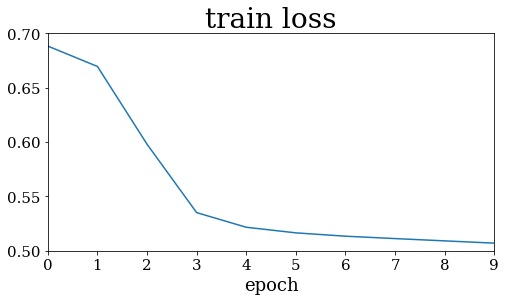

In [285]:
plt.title("train loss")
plt.plot( autoencoder_train.history["loss"])
plt.rcParams["figure.figsize"] = (16,8)
plt.xlabel("epoch");

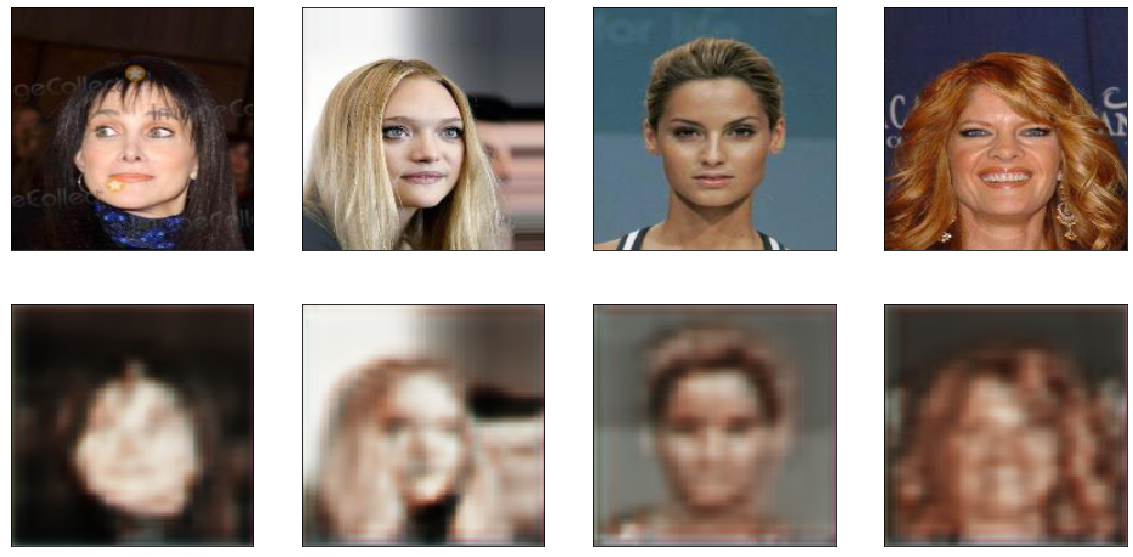

In [205]:
decoded_imgs = autoencoder.predict(X_test)

n = 4
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(200, 200, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(200, 200, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [80]:
saved_model_path = "saved_models/base_auto.h5"
model = keras.models.load_model(saved_model_path)

In [81]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 8)         0   

In [193]:
new_model = keras.models.Sequential()
for layer in model.layers[:-7]: # just exclude the last 7 FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 100, 100, 8)       1160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 50, 50, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 50, 50, 8)         584       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 8)         0         
Total params: 2,192
Trainable params: 0
Non-trainable params: 2,192
____________________________________________________

In [279]:
def graph_encoded_layer(num):
    for k in range(num):
        plt.figure(figsize=(50, 25))
        for i in range(8):
            ax = plt.subplot(2, 4, i+1)
            plt.imshow(decoded_imgs[k,:,:,i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

In [278]:
decoded_imgs = new_model.predict(X_test)

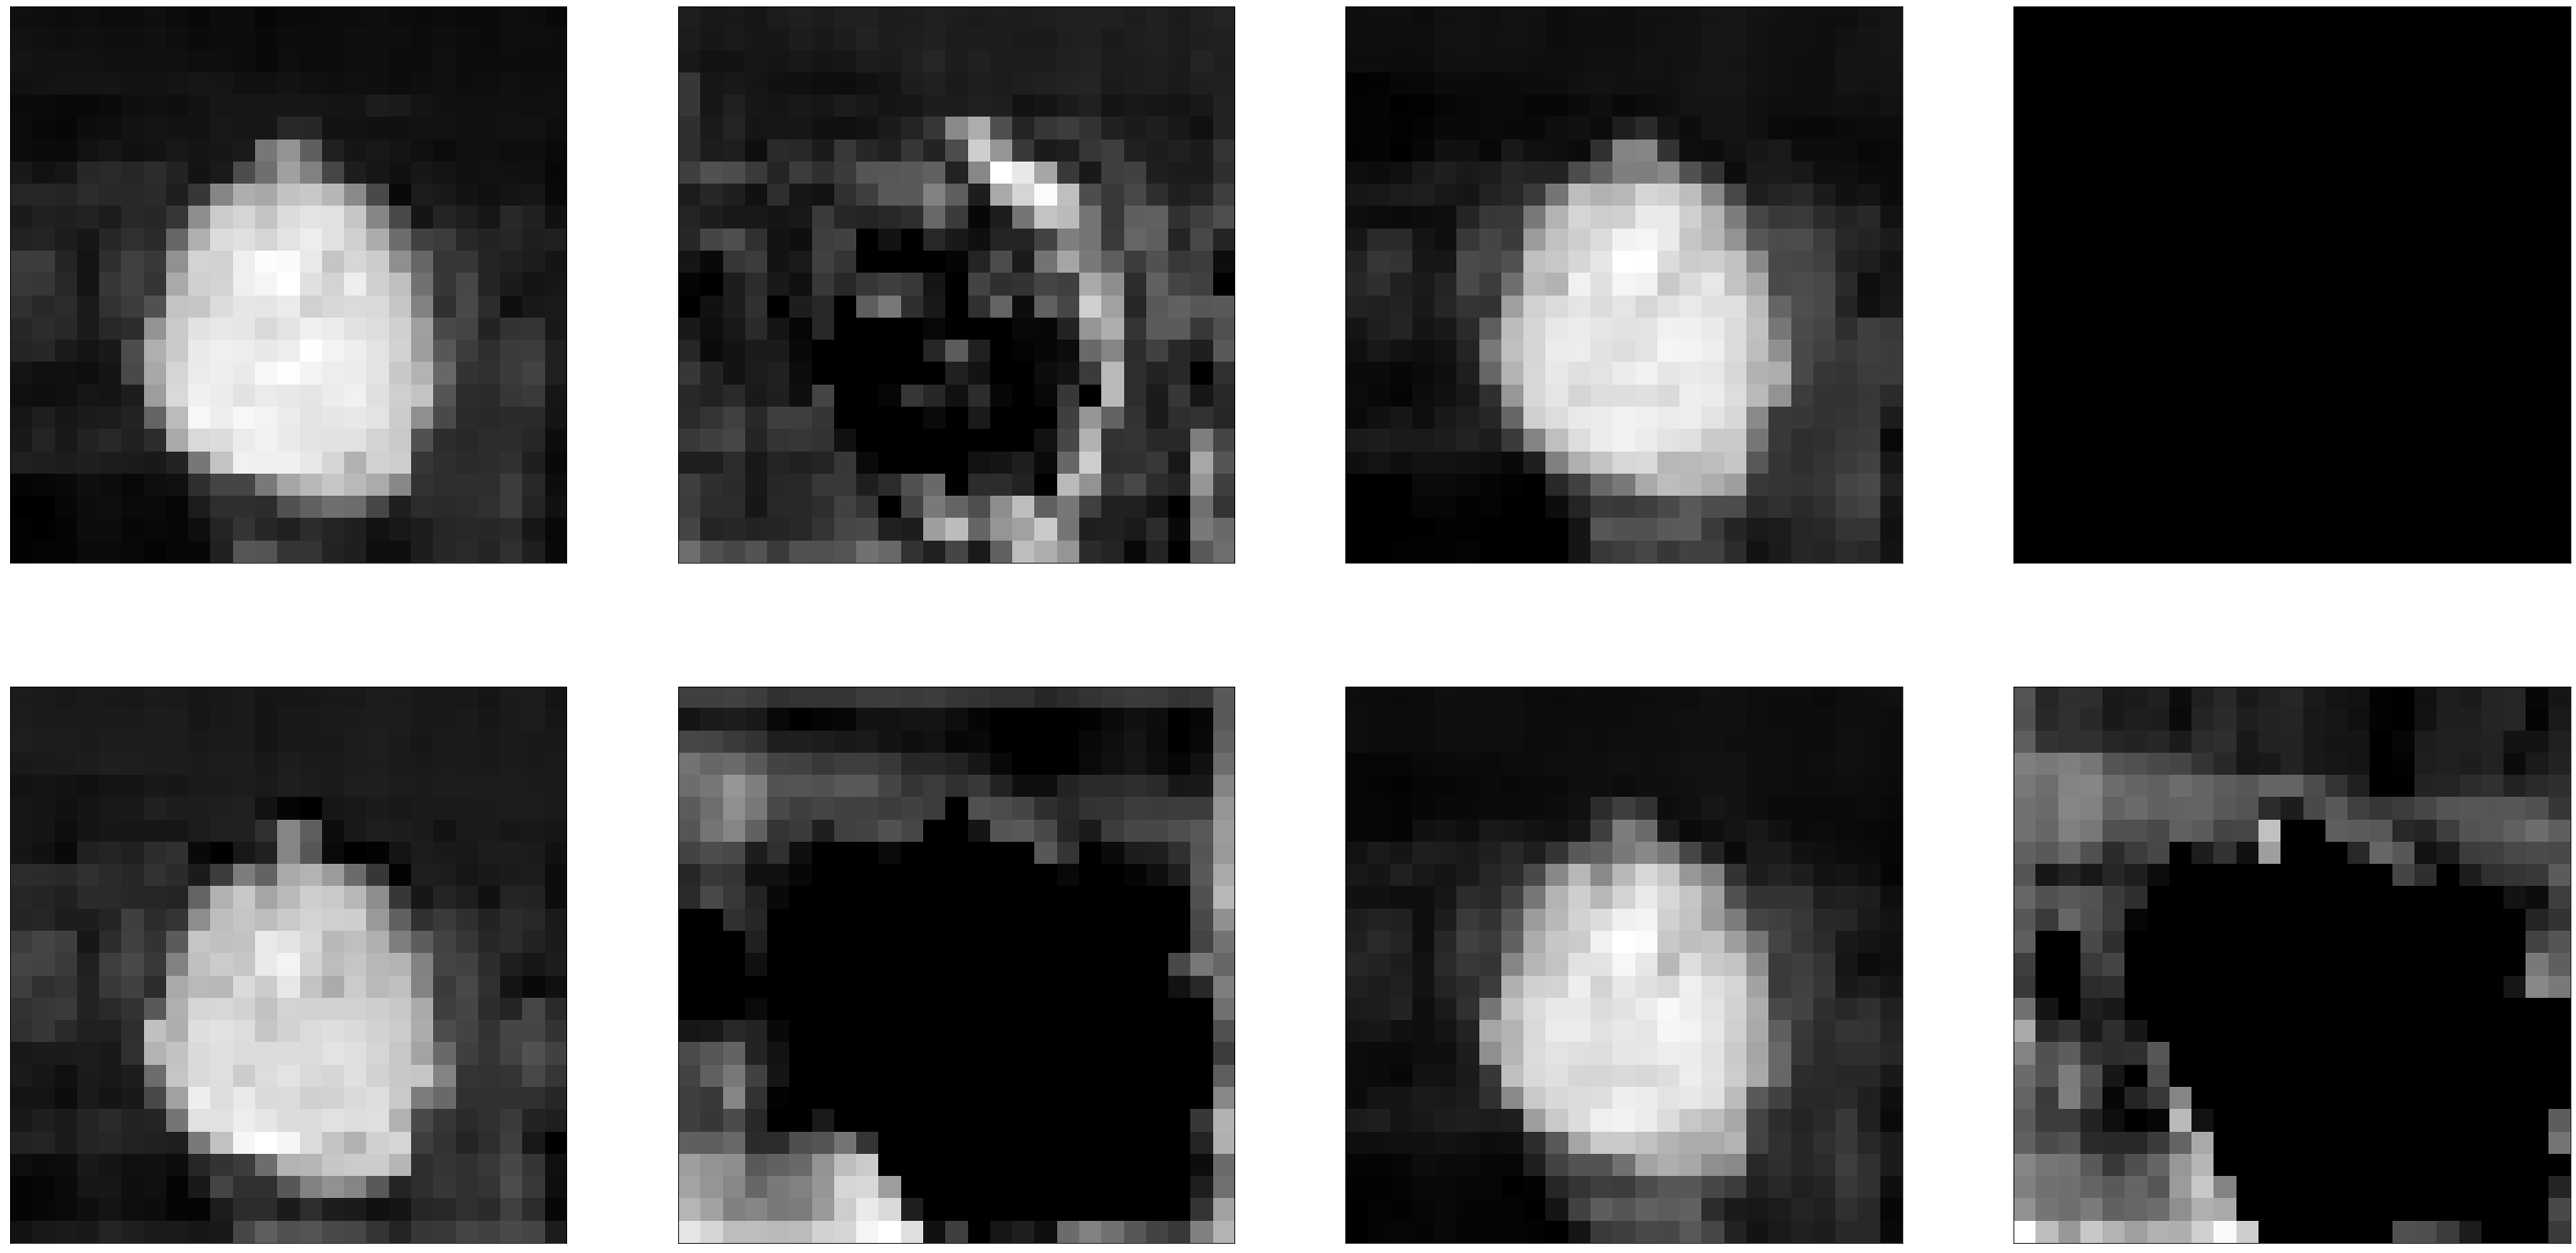

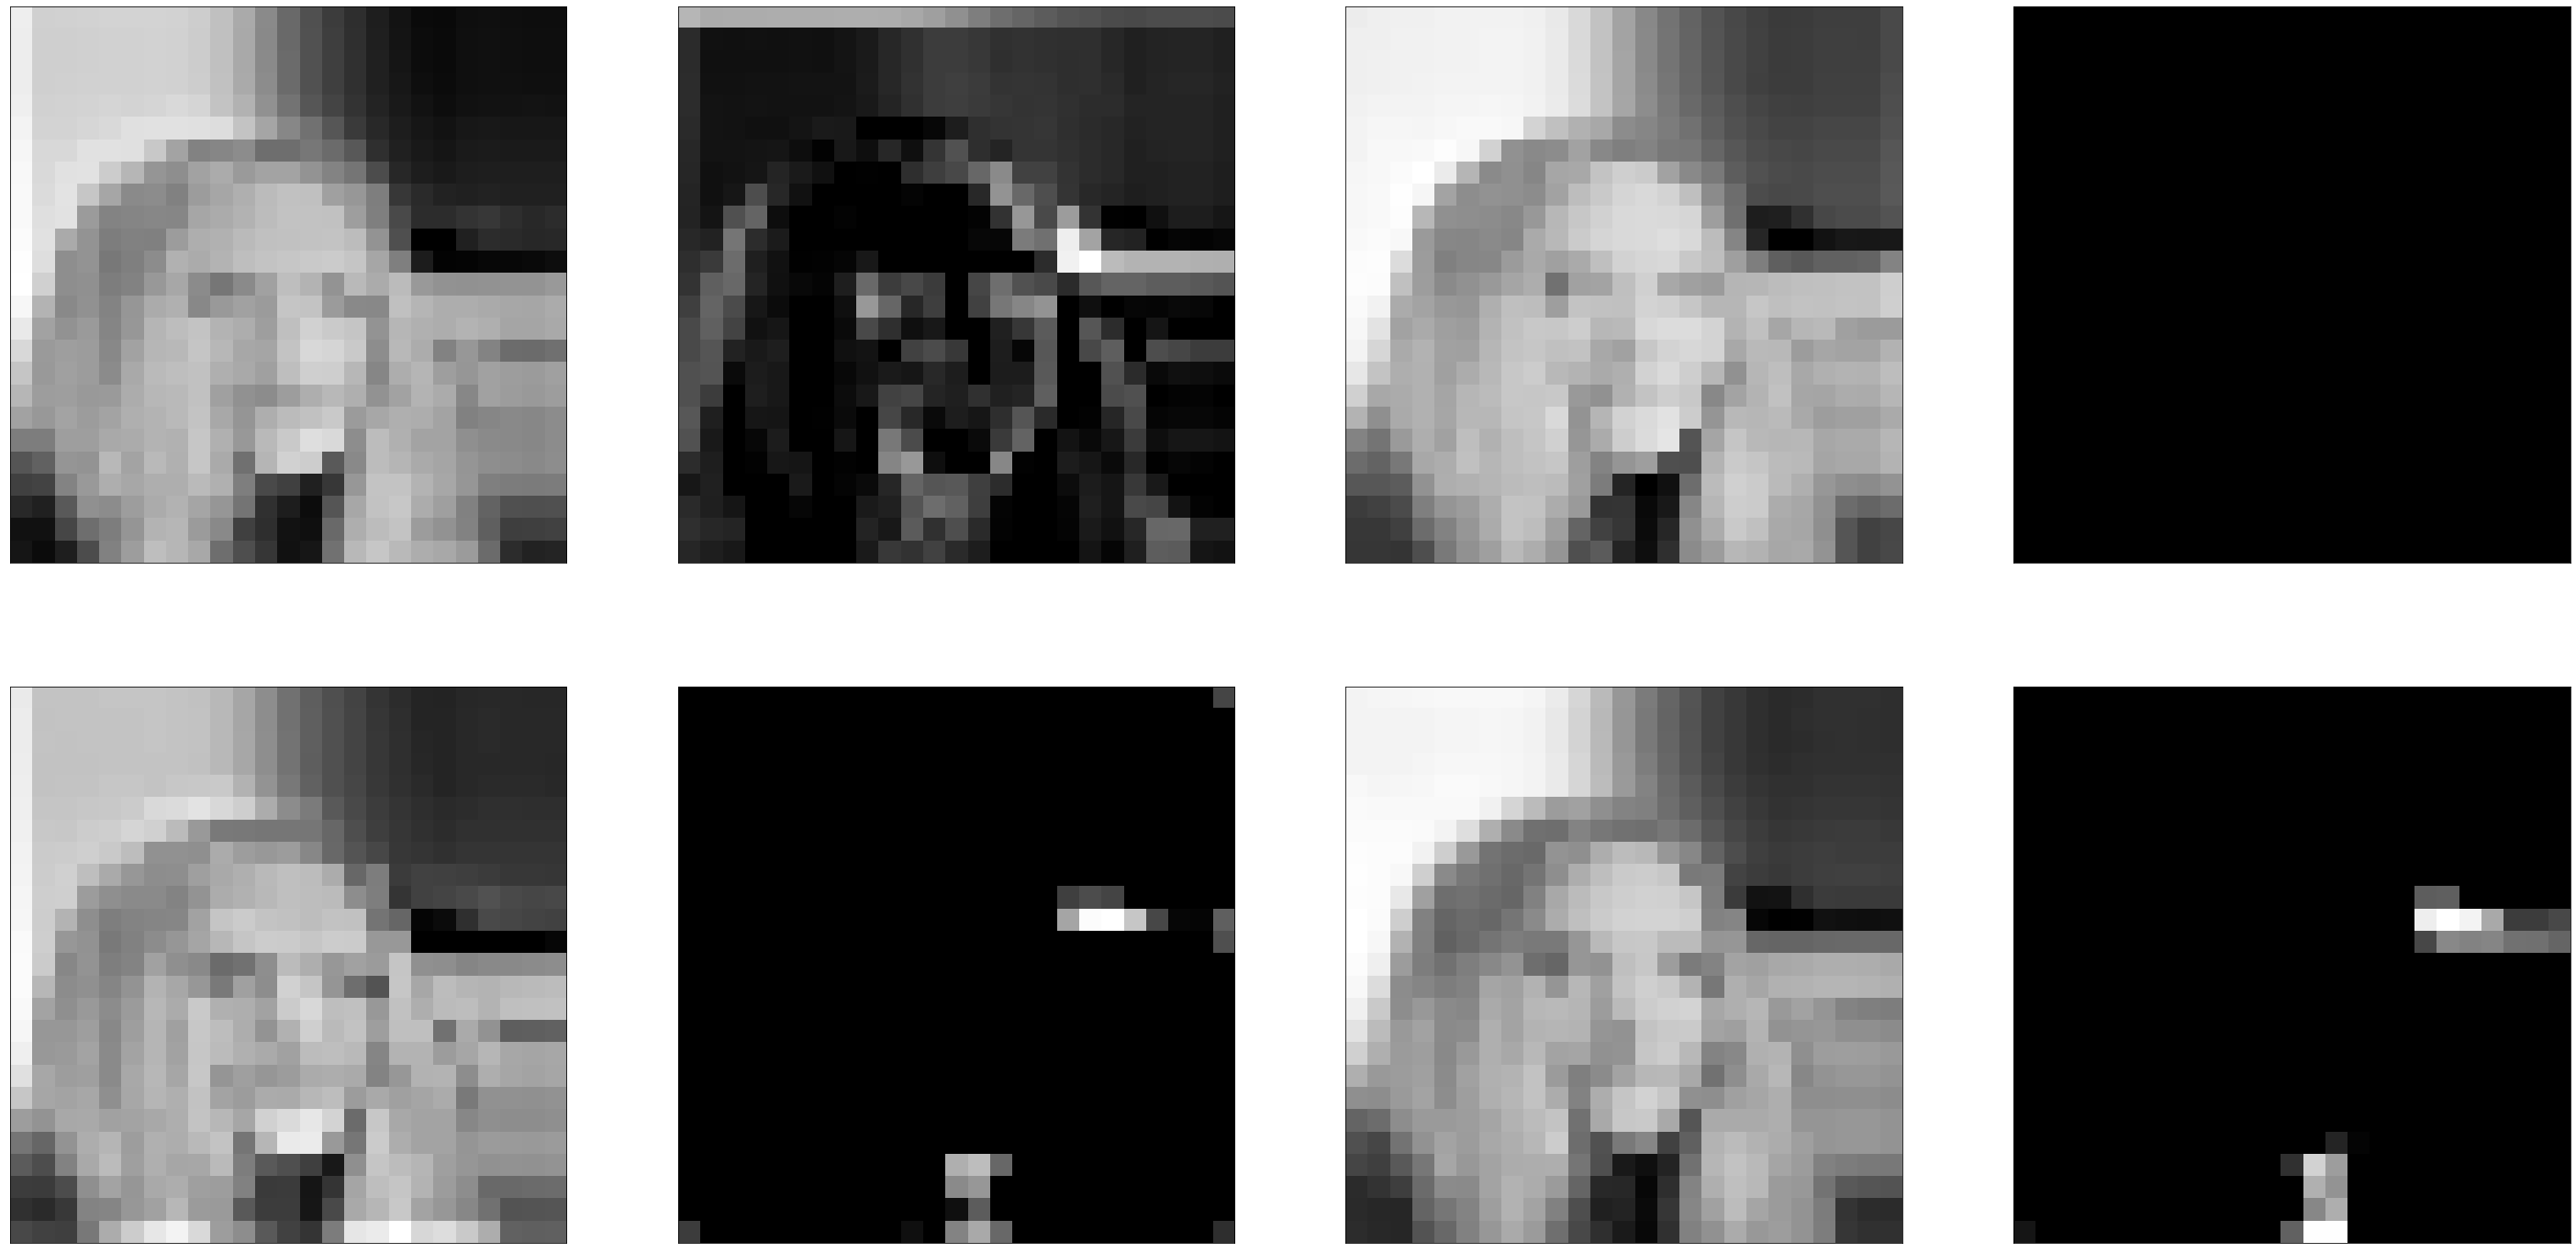

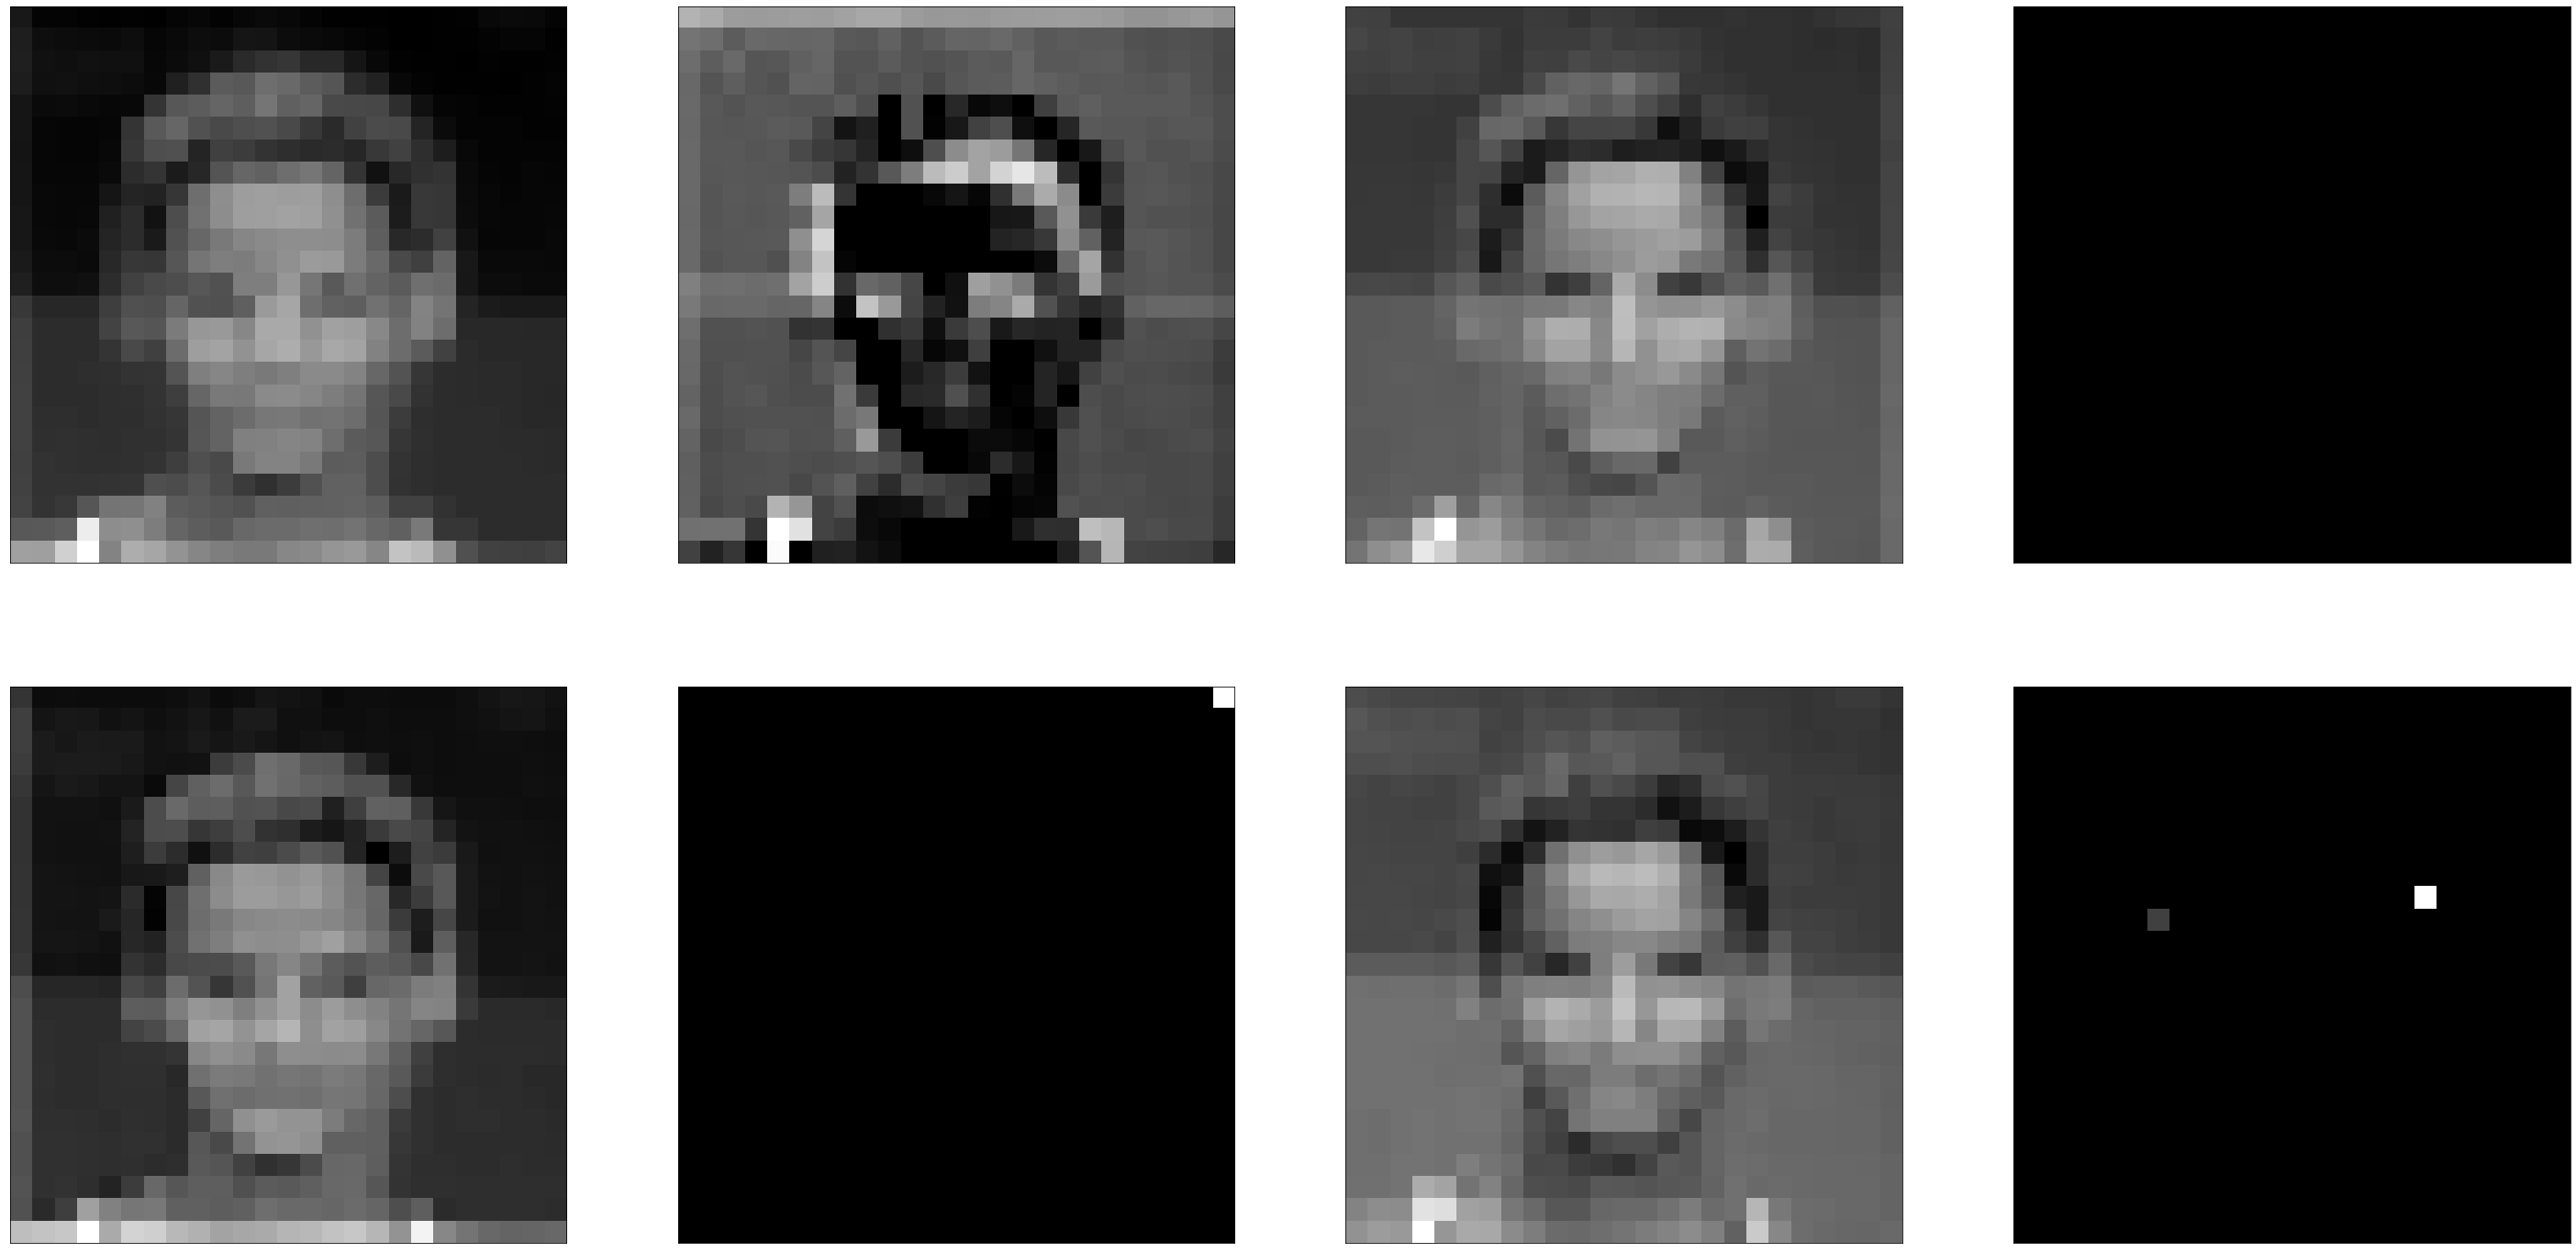

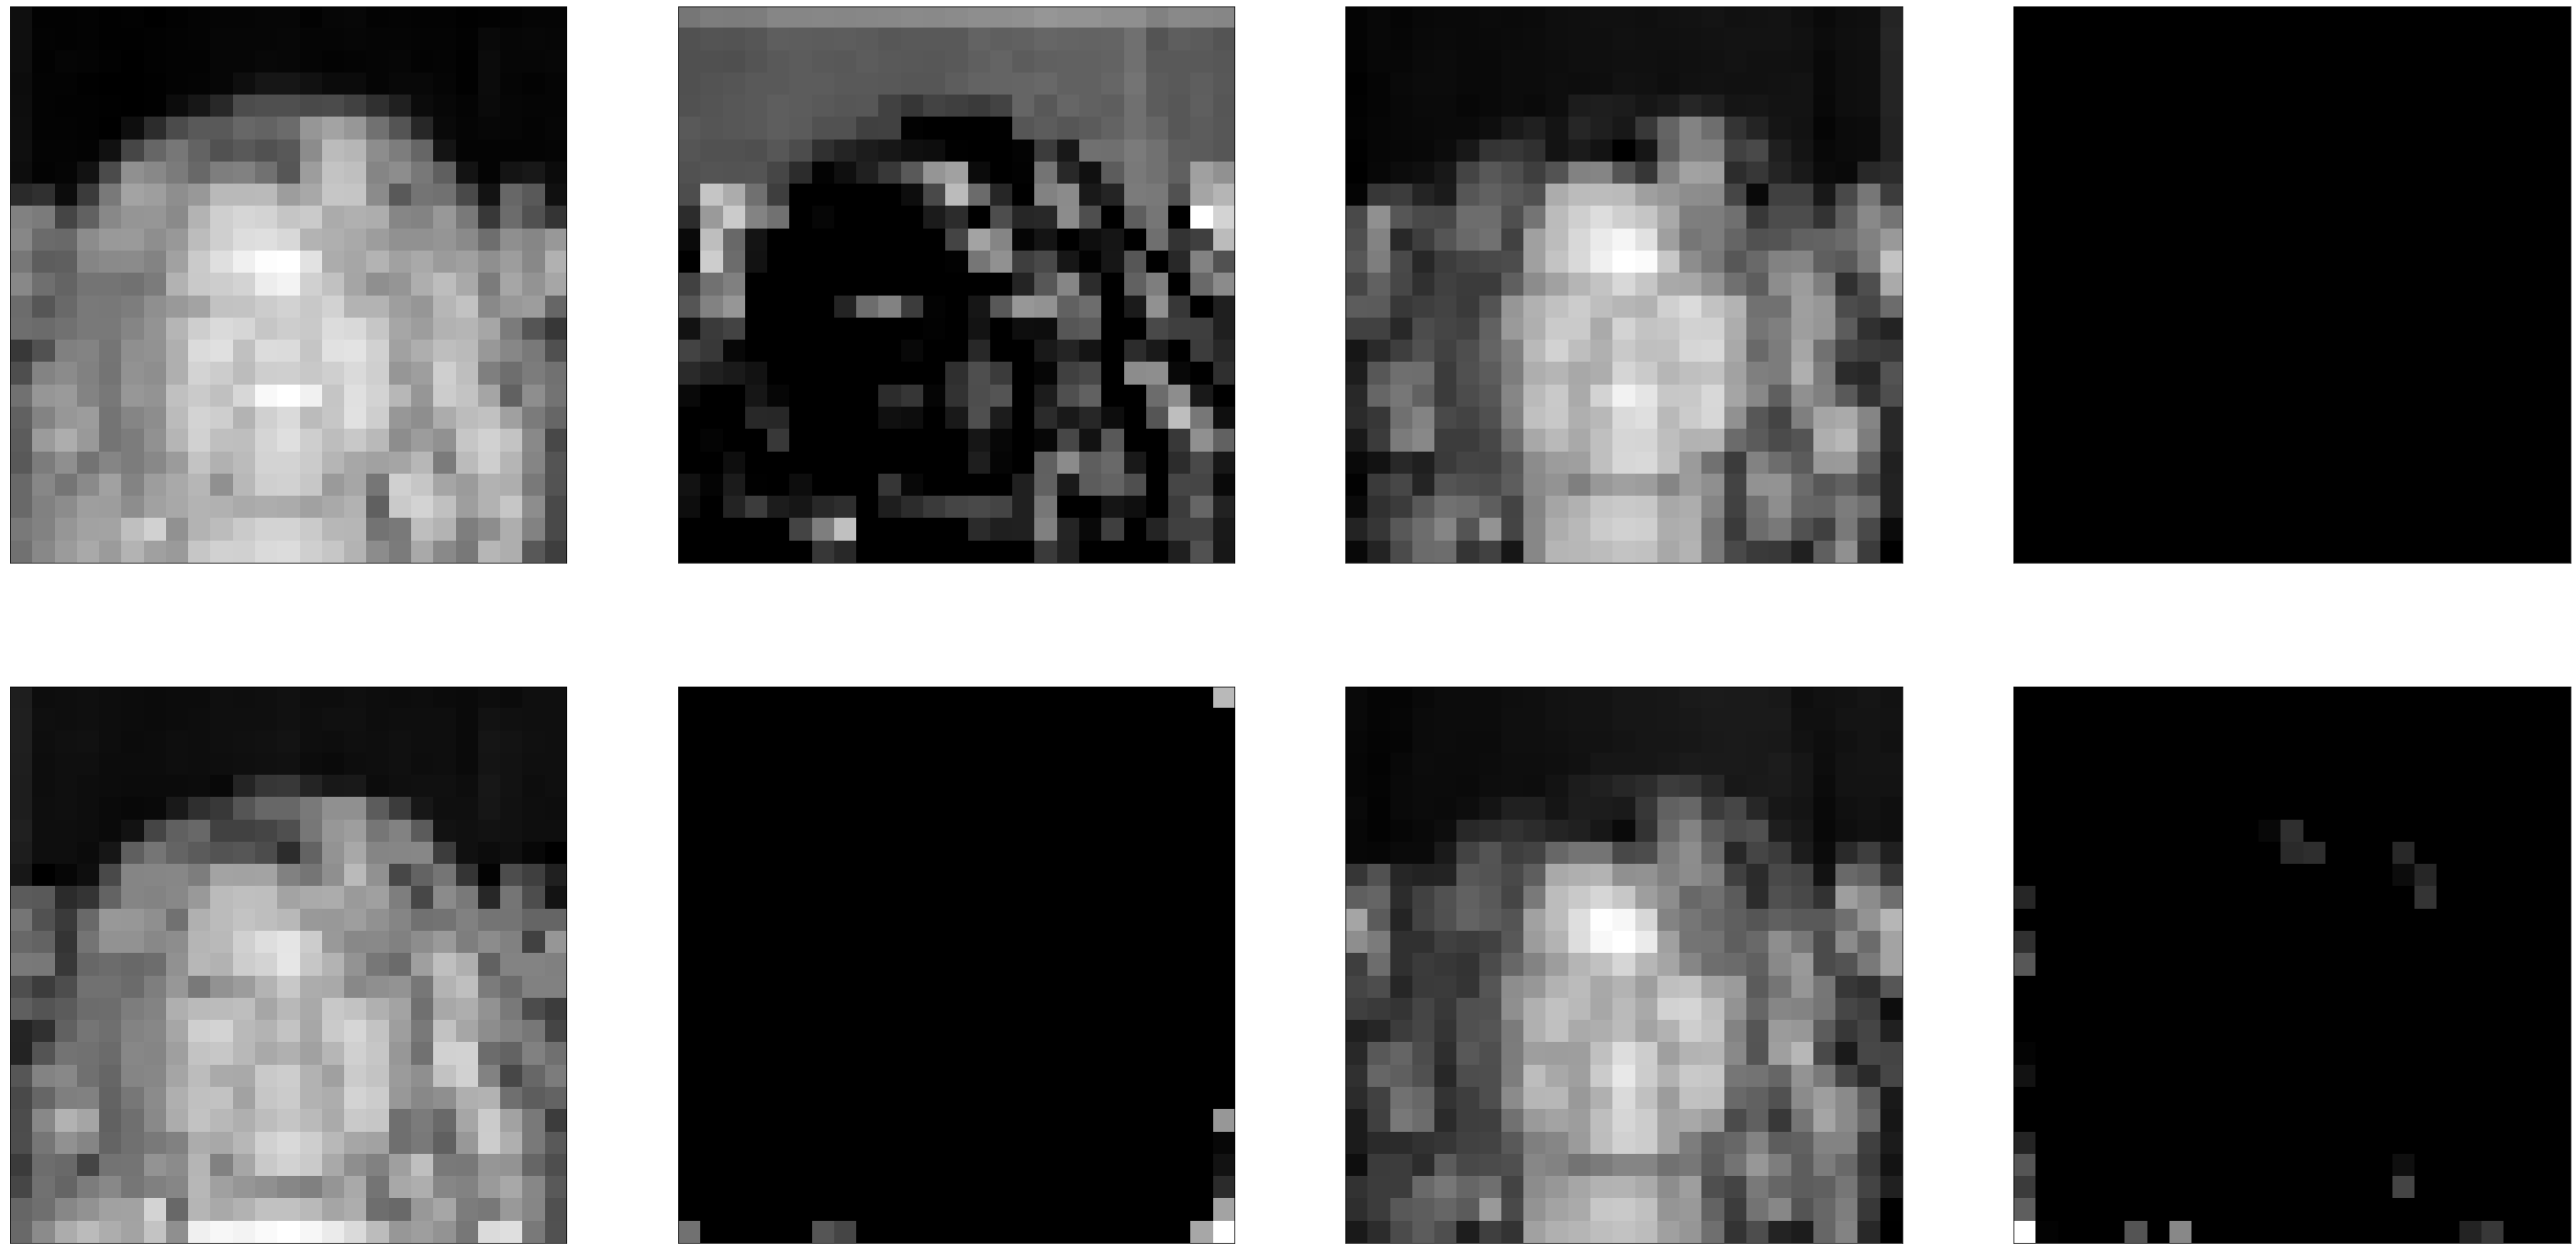

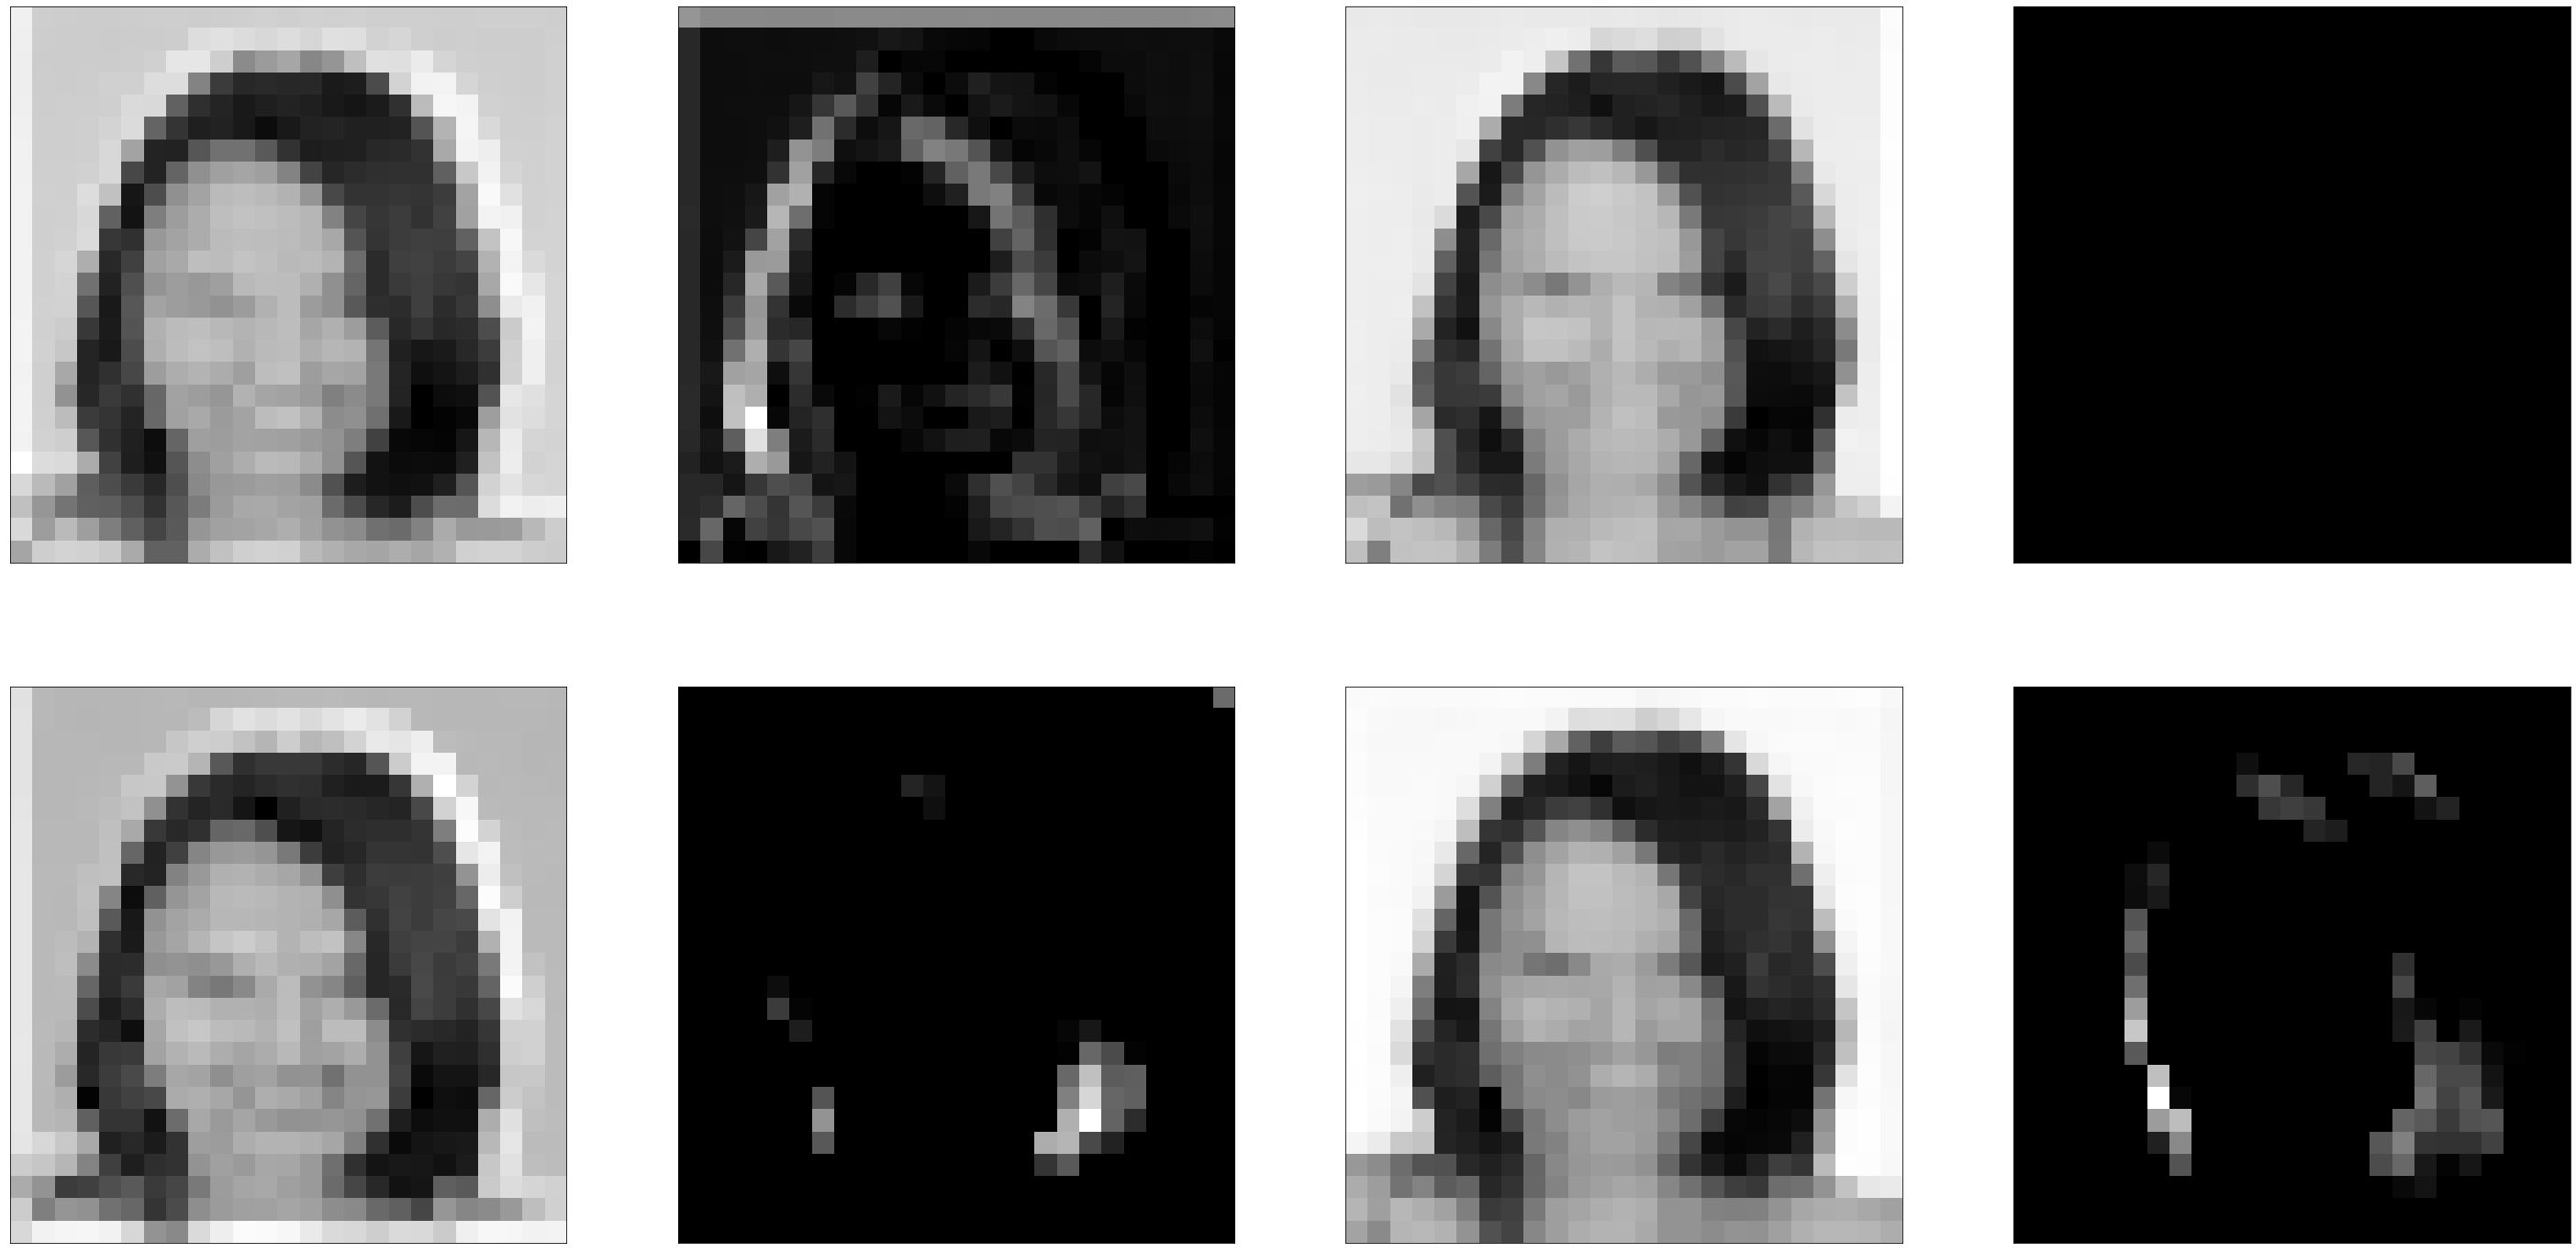

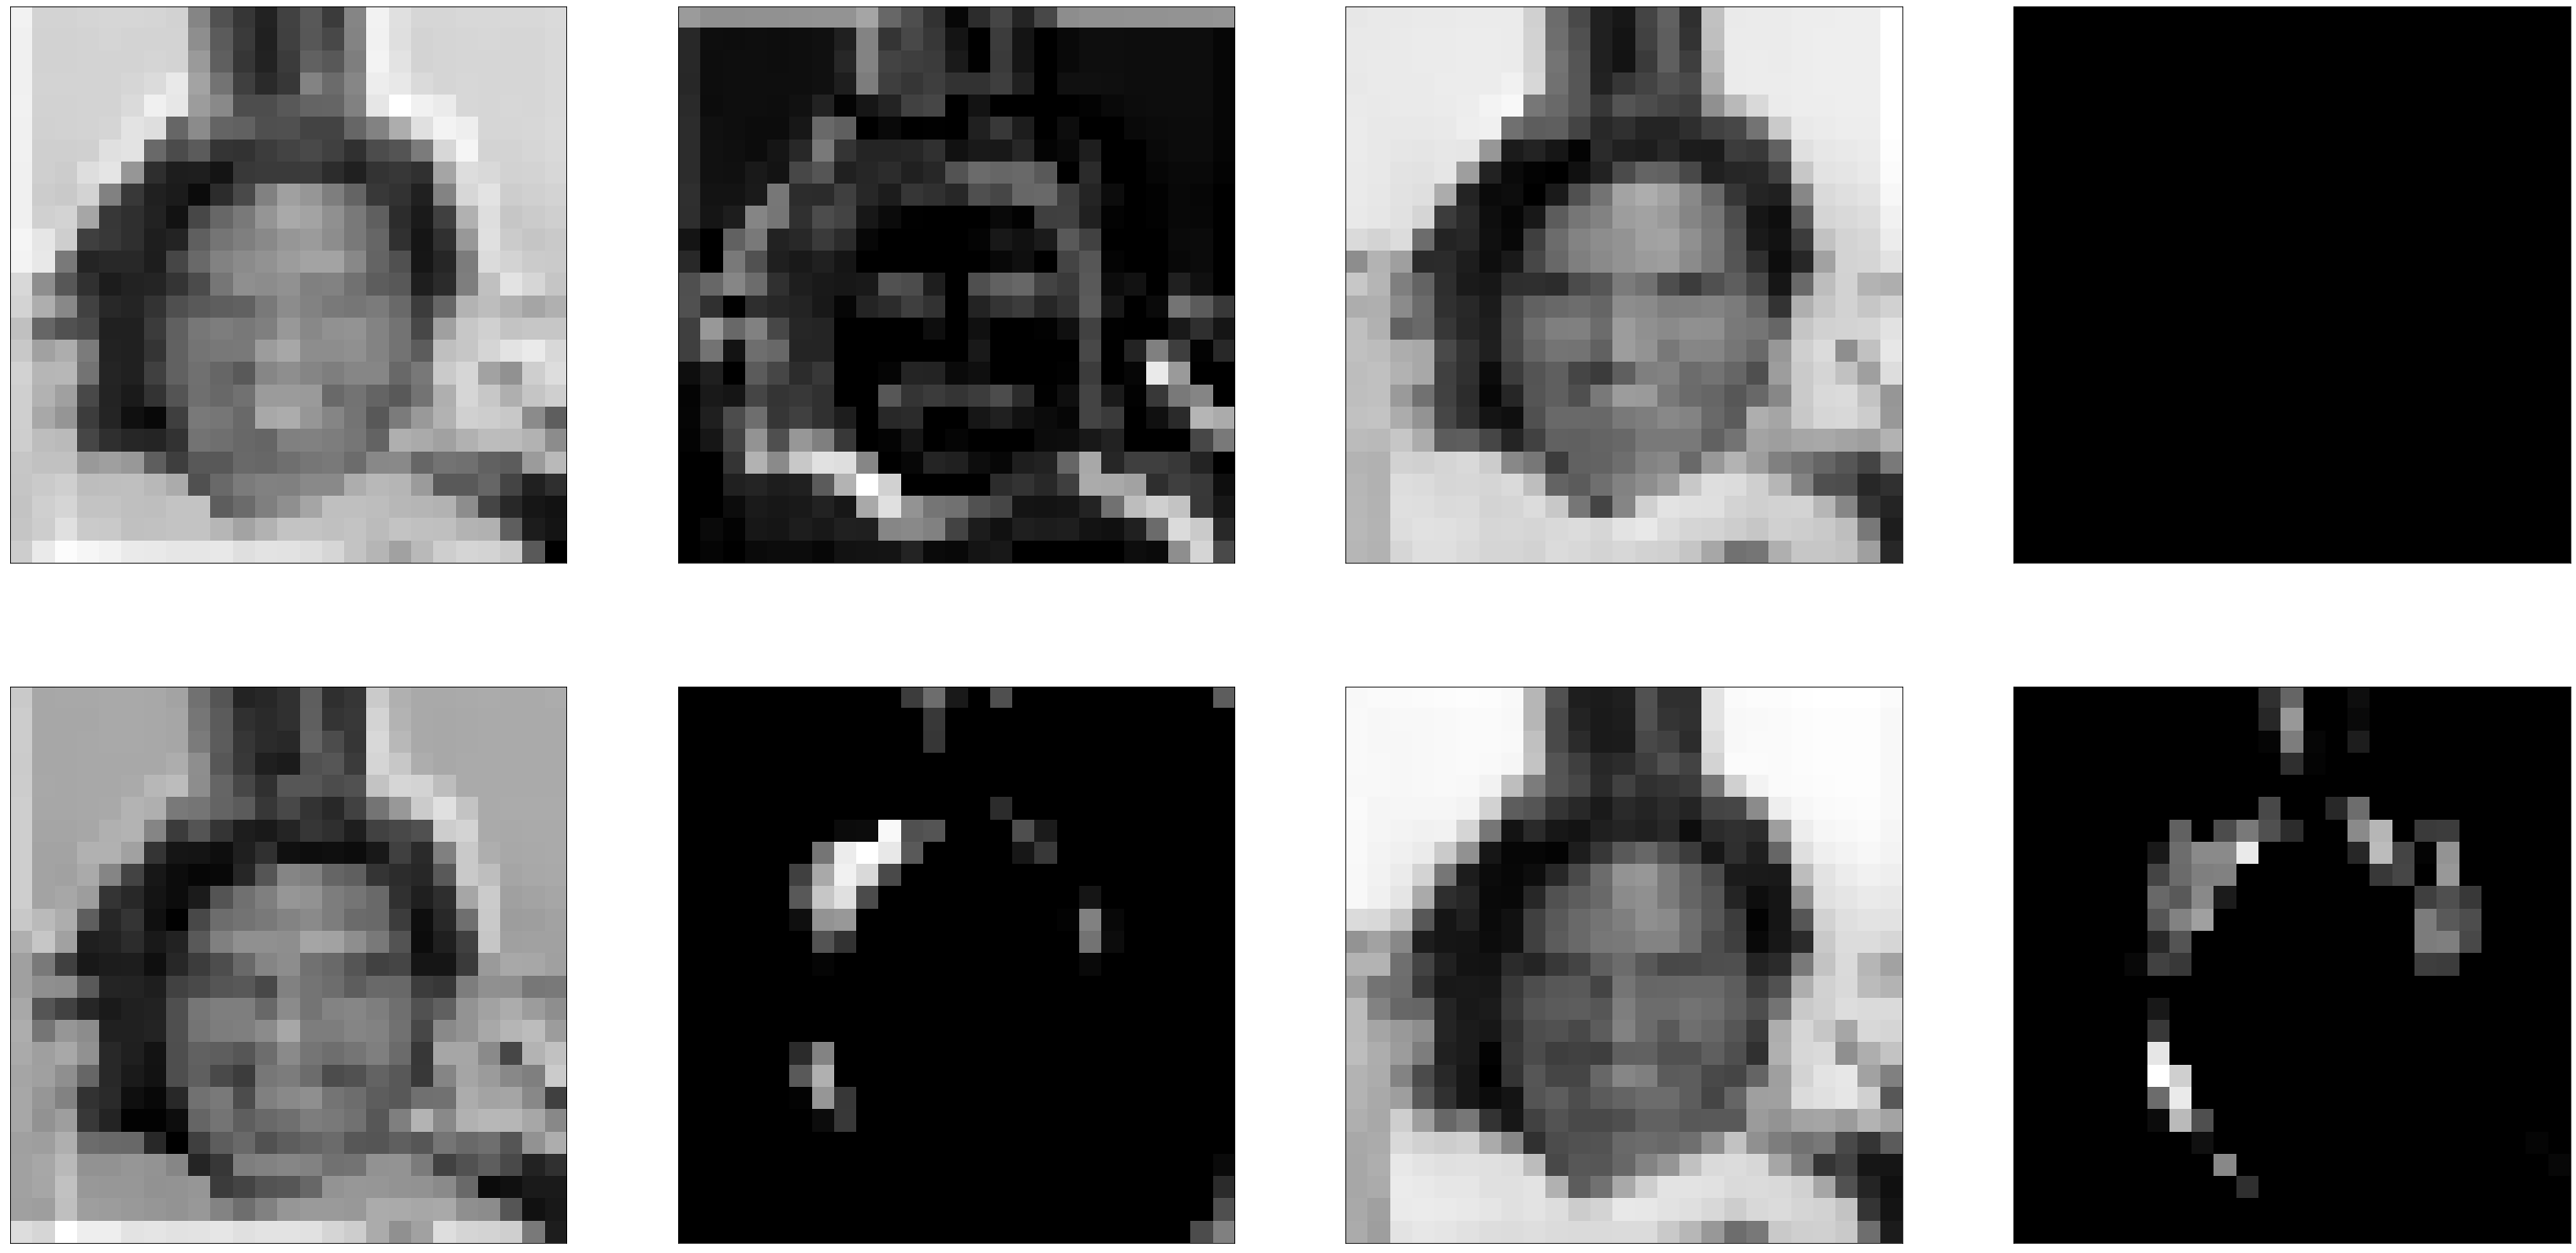

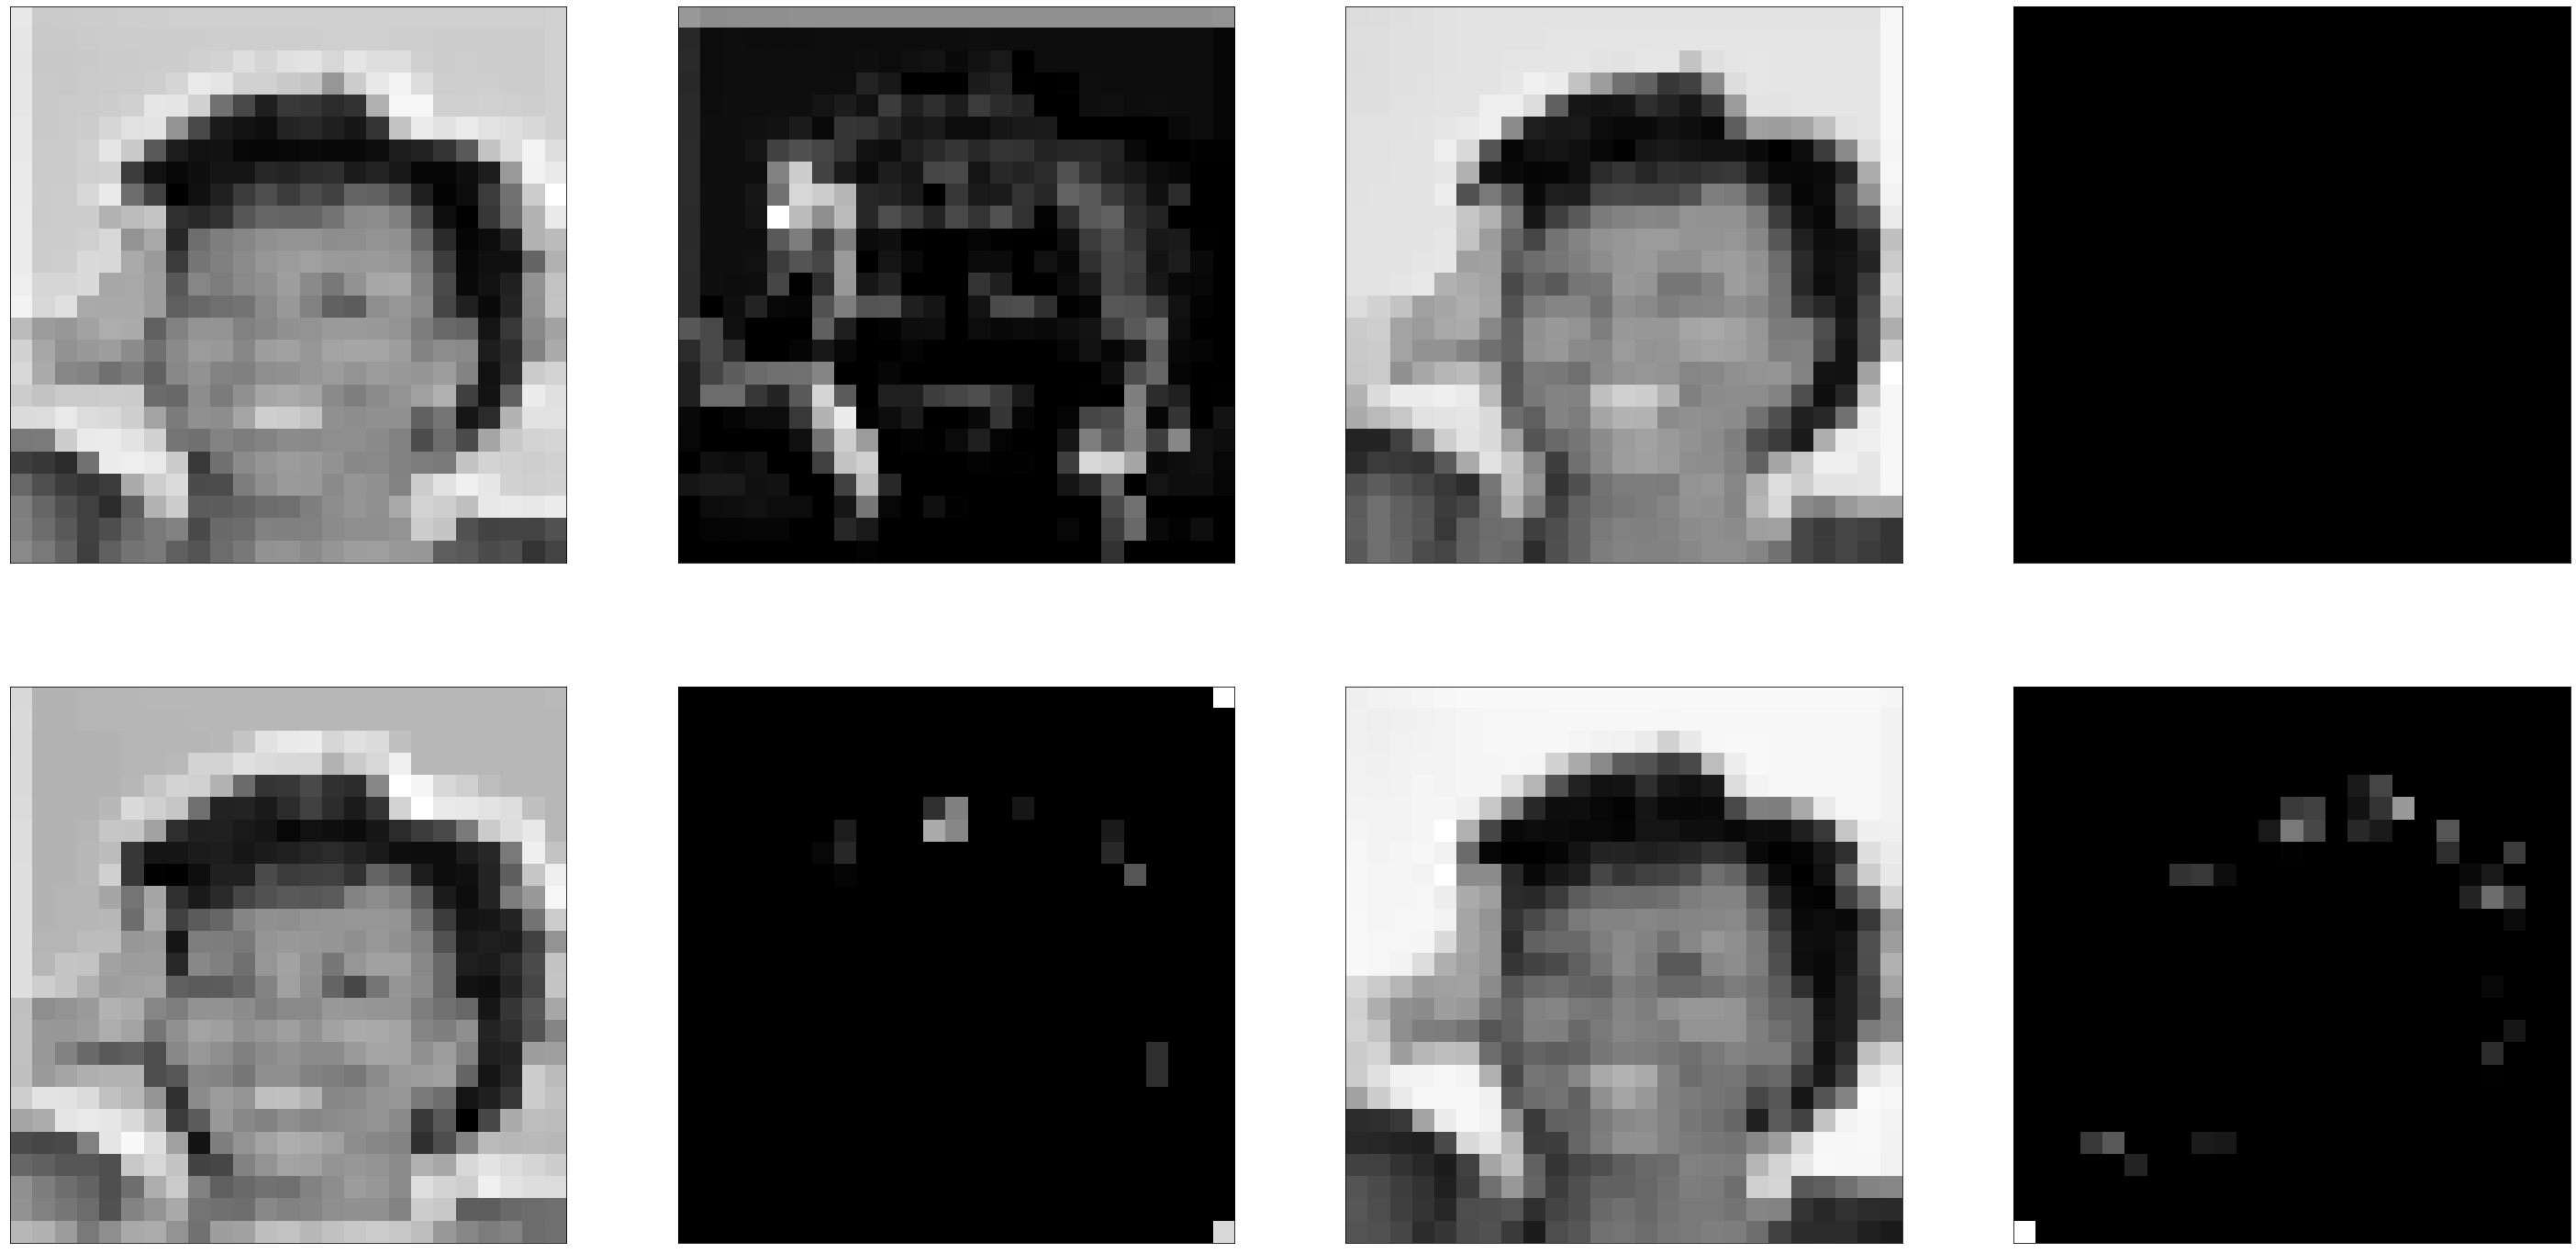

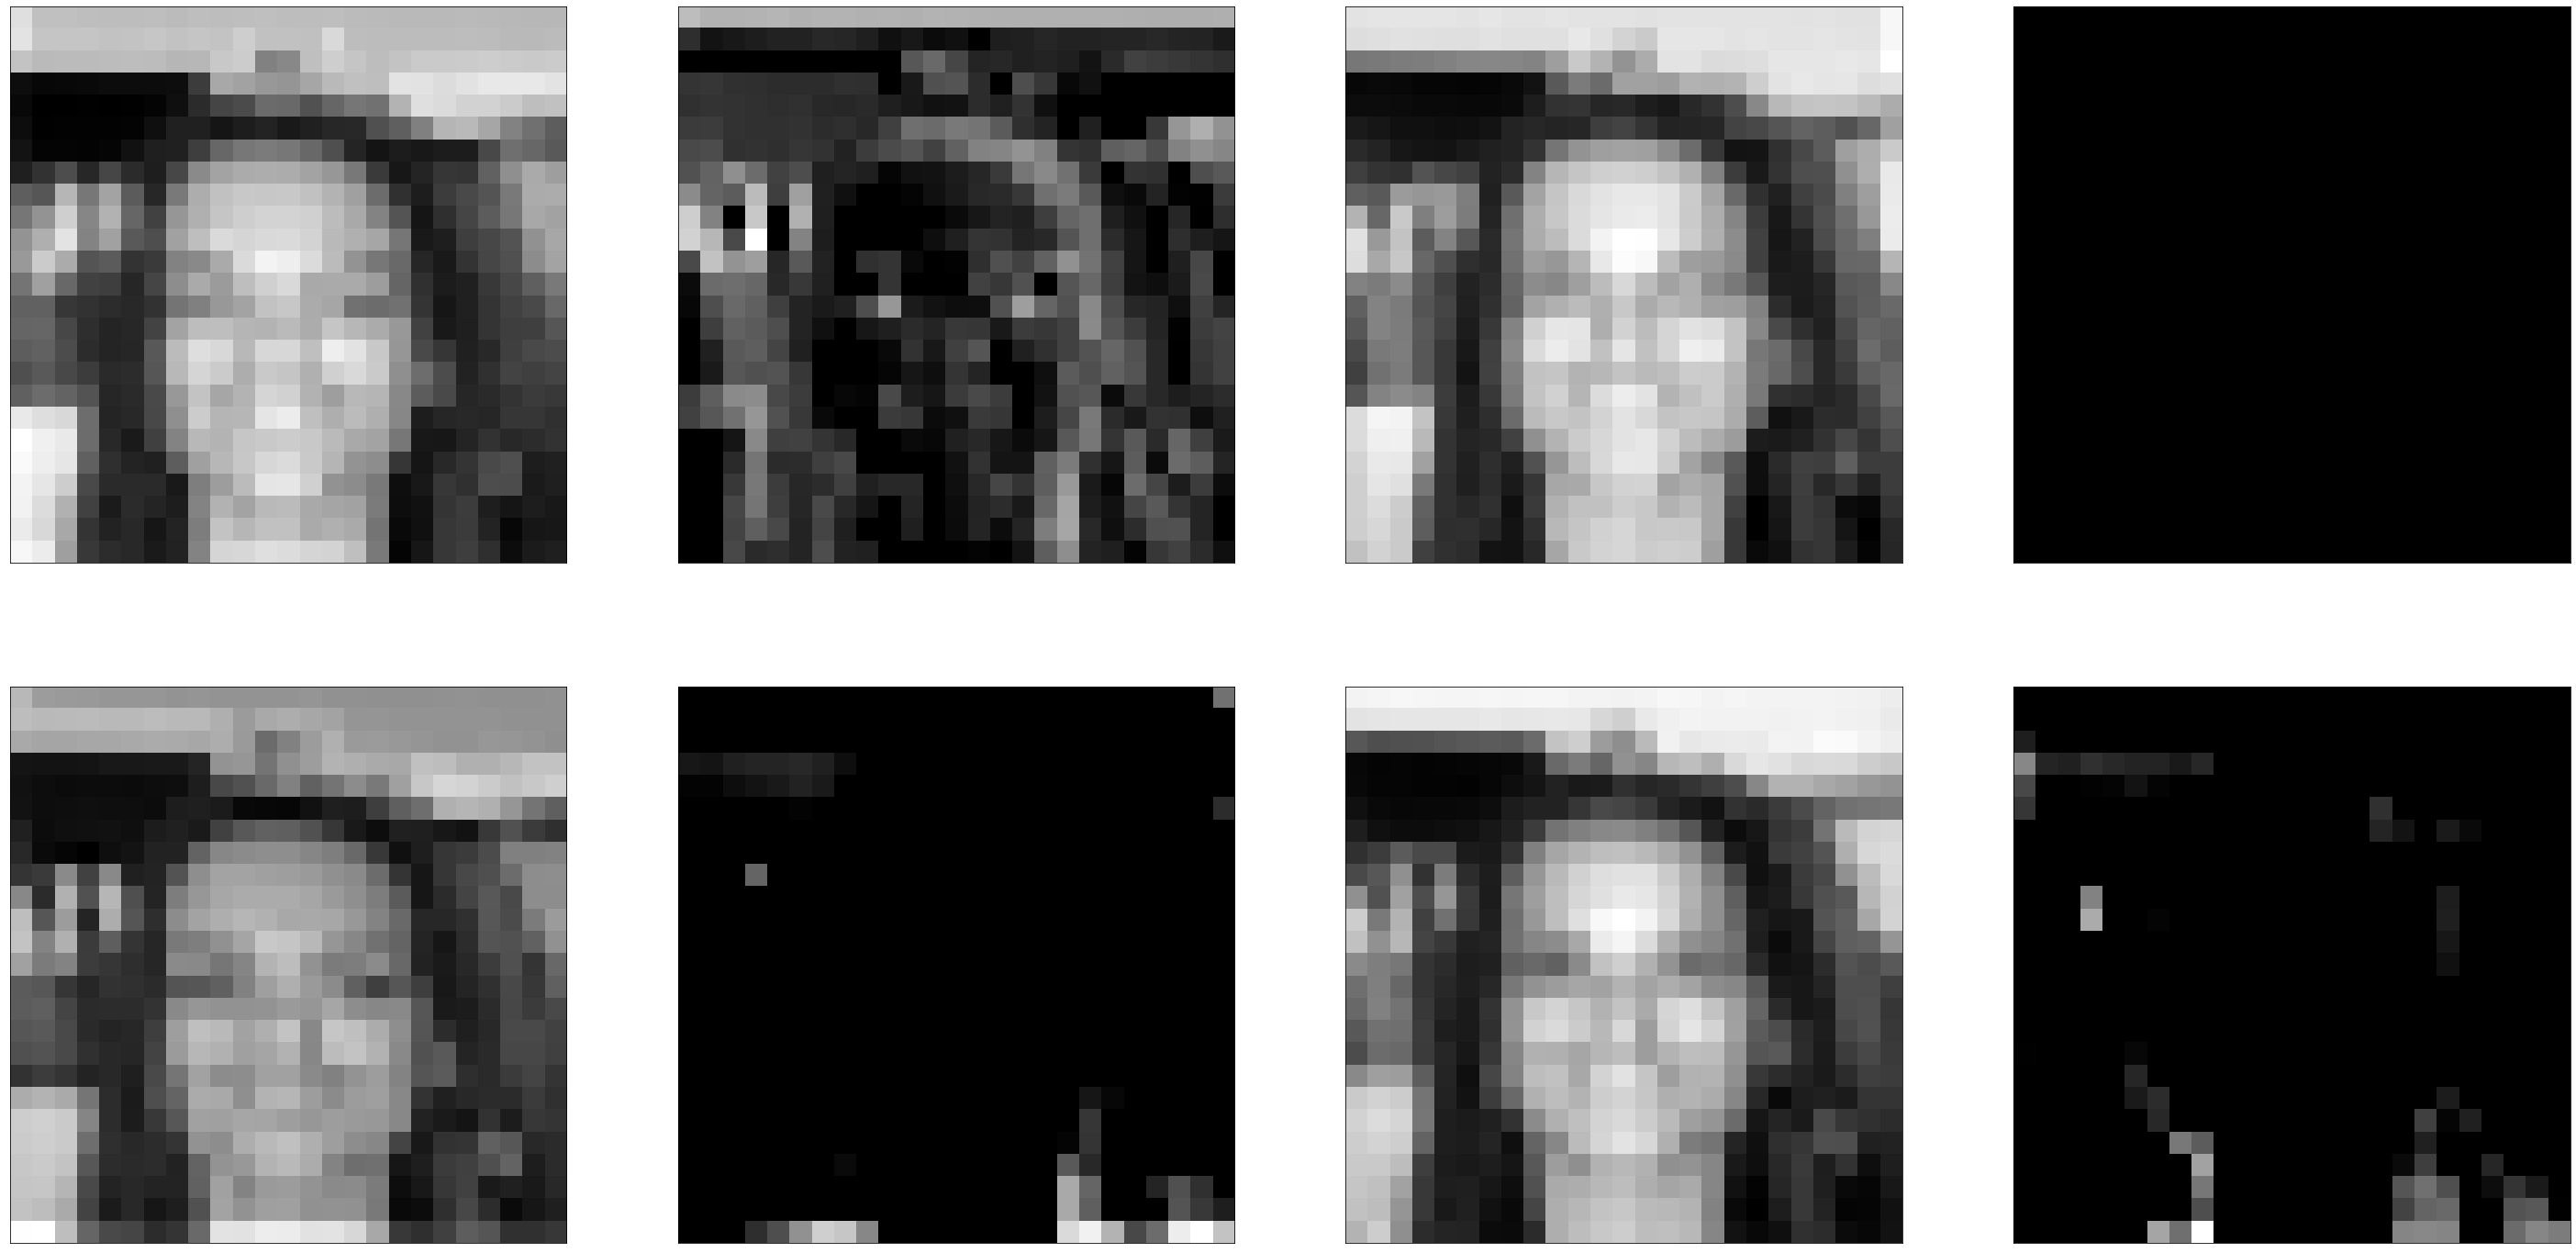

In [281]:
graph_encoded_layer(1)

### Model Building 2 (40 layer dip)

In [18]:
input_img = Input(shape=(200, 200, 3)) 

x = Conv2D(40, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(40, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 200, 200, 40)      1120      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 100, 40)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 100, 100, 20)      7220      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 50, 20)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 50, 50, 20)        3620      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 25, 25, 20)        0   

In [20]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [21]:
%%time
autoencoder_train = autoencoder.fit(
    X_train, X_train,
    validation_data = (X_test,X_test),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1500 samples, validate on 500 samples
Epoch 1/10
1500/1500 [==============================] - 103s 69ms/step - loss: 0.5834 - val_loss: 0.5111
Epoch 2/10
1500/1500 [==============================] - 103s 68ms/step - loss: 0.5034 - val_loss: 0.5002
Epoch 3/10
1500/1500 [==============================] - 104s 69ms/step - loss: 0.4939 - val_loss: 0.4918
Epoch 4/10
1500/1500 [==============================] - 103s 69ms/step - loss: 0.4901 - val_loss: 0.4919
Epoch 5/10
1500/1500 [==============================] - 101s 67ms/step - loss: 0.4886 - val_loss: 0.4888
Epoch 6/10
1500/1500 [==============================] - 101s 67ms/step - loss: 0.4878 - val_loss: 0.4878
Epoch 7/10
1500/1500 [==============================] - 102s 68ms/step - loss: 0.4868 - val_loss: 0.4877
Epoch 8/10
1500/1500 [==============================] - 104s 70ms/step - loss: 0.4867 - val_loss: 0.4867
Epoch 9/10
1500/1500 [==============================] - 102s 68ms/step - loss: 0.4856 - val_loss: 0.4863
Epoch 10

In [22]:
saved_model_path = "saved_models/40layers_auto_2.h5" # _%H%M%S
# Save entire model to a HDF5 file
autoencoder.save(saved_model_path)

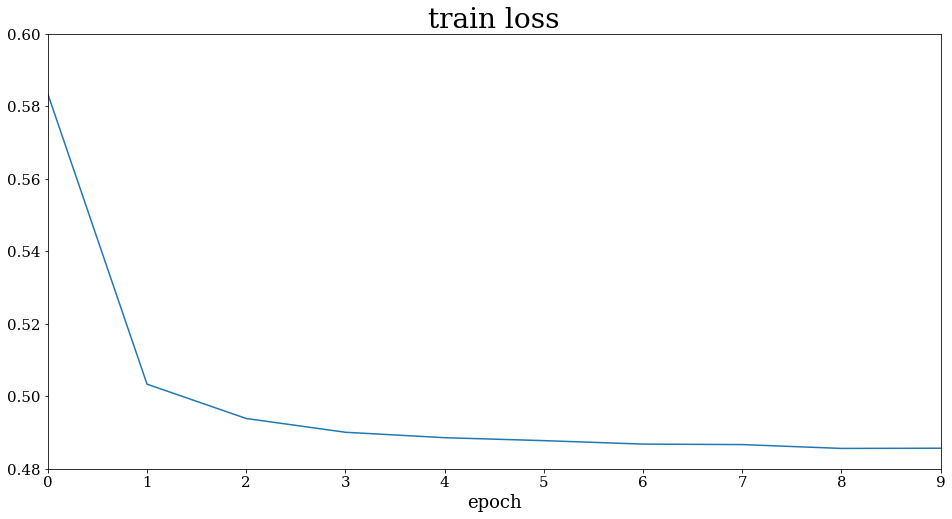

In [23]:
plt.title("train loss")
plt.plot( autoencoder_train.history["loss"])
plt.rcParams["figure.figsize"] = (16,8)
plt.xlabel("epoch");

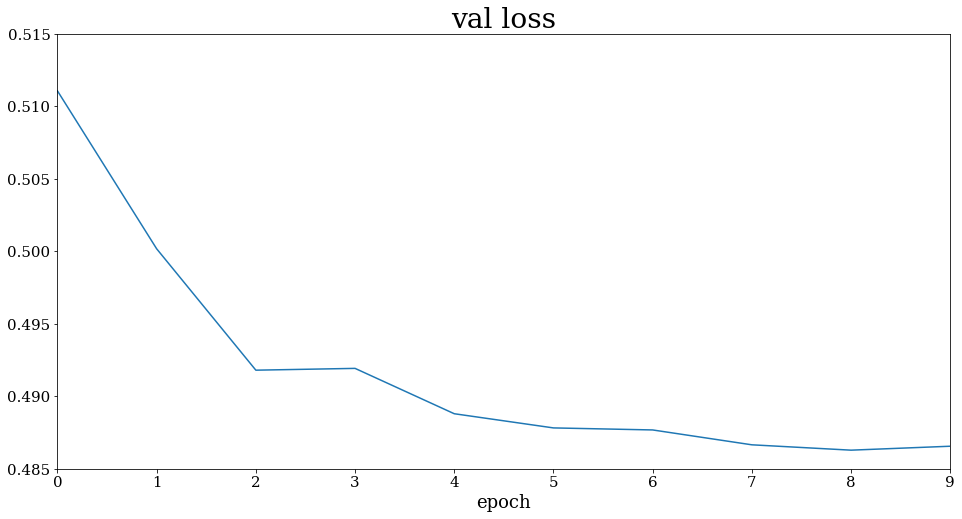

In [291]:
plt.title("val loss")
plt.plot( autoencoder_train.history["val_loss"])
plt.rcParams["figure.figsize"] = (16,8)
plt.xlabel("epoch");

In [42]:
def graph_encoded_layer(num):
    for k in range(num):
        plt.figure(figsize=(50, 50))
        for i in range(20):
            ax = plt.subplot(5, 5, i+1)
            plt.imshow(decoded_imgs[k,:,:,i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

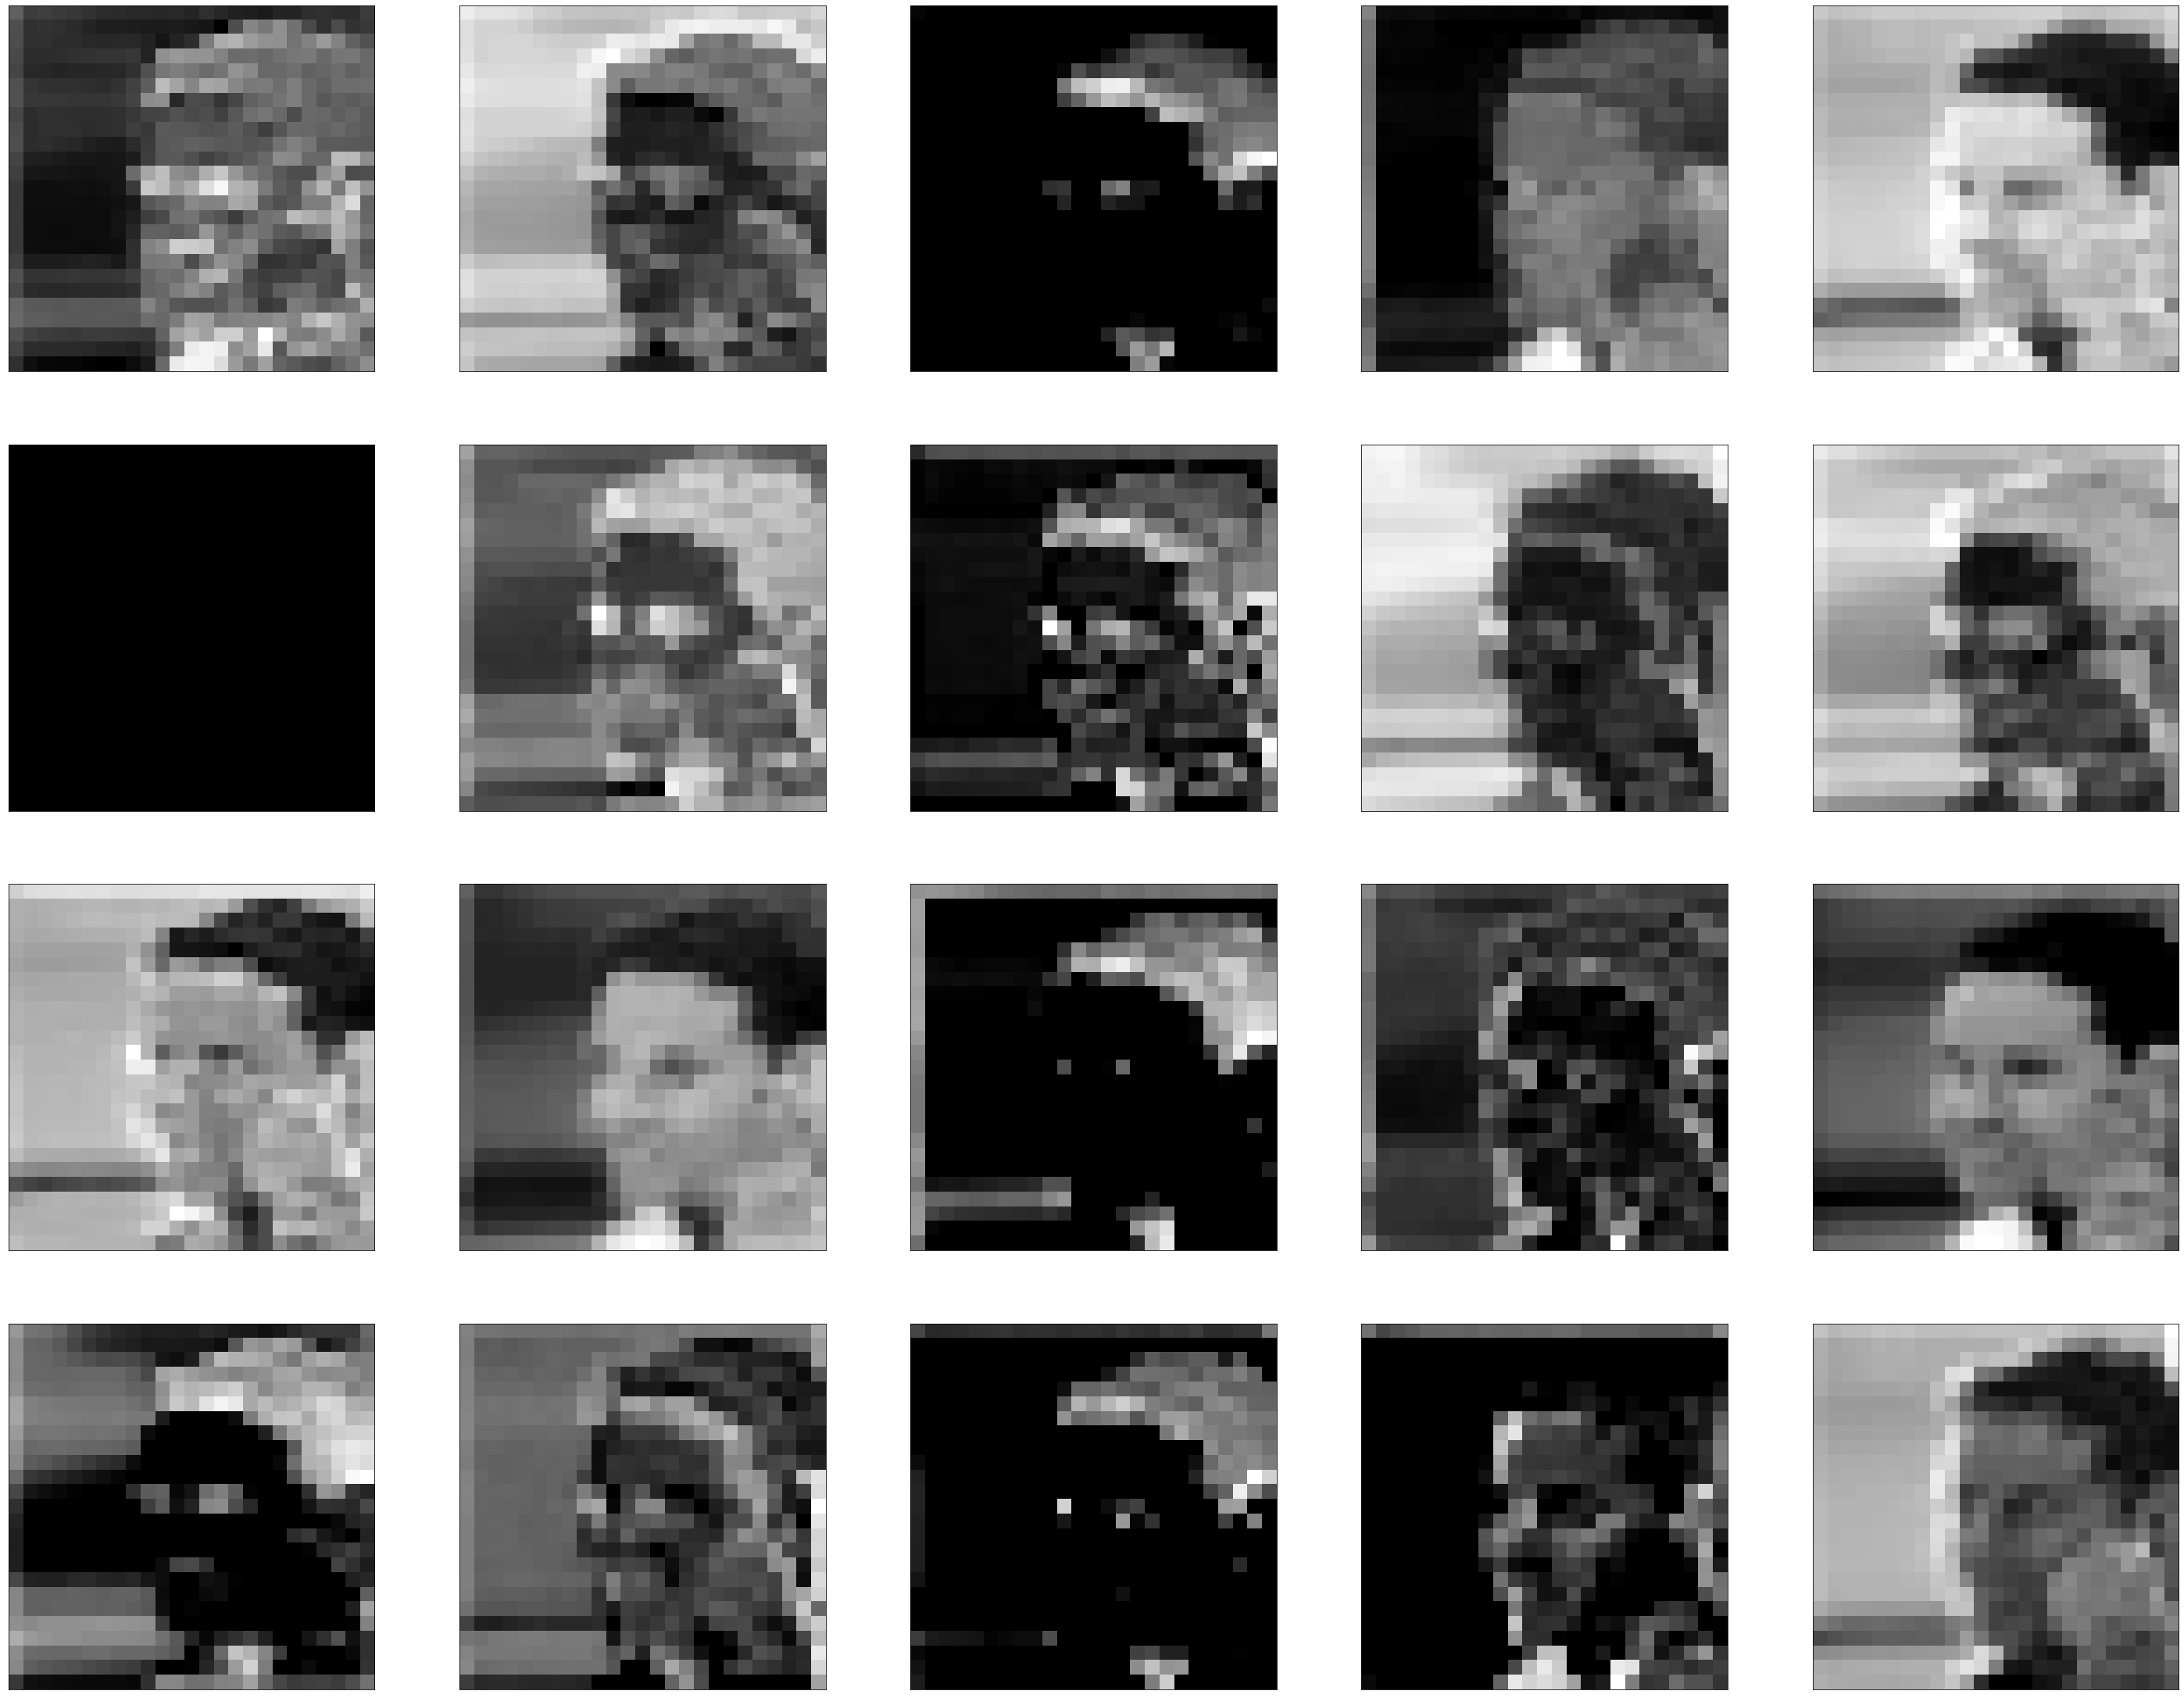

In [43]:
saved_model_path = "saved_models/40layers_auto_2.h5"
model = keras.models.load_model(saved_model_path)
new_model = keras.models.Sequential()
for layer in model.layers[:-7]: # just exclude the last 7 FC layers
    layer.trainable = False
    new_model.add(layer)
decoded_imgs = new_model.predict(X_test)
graph_encoded_layer(1)

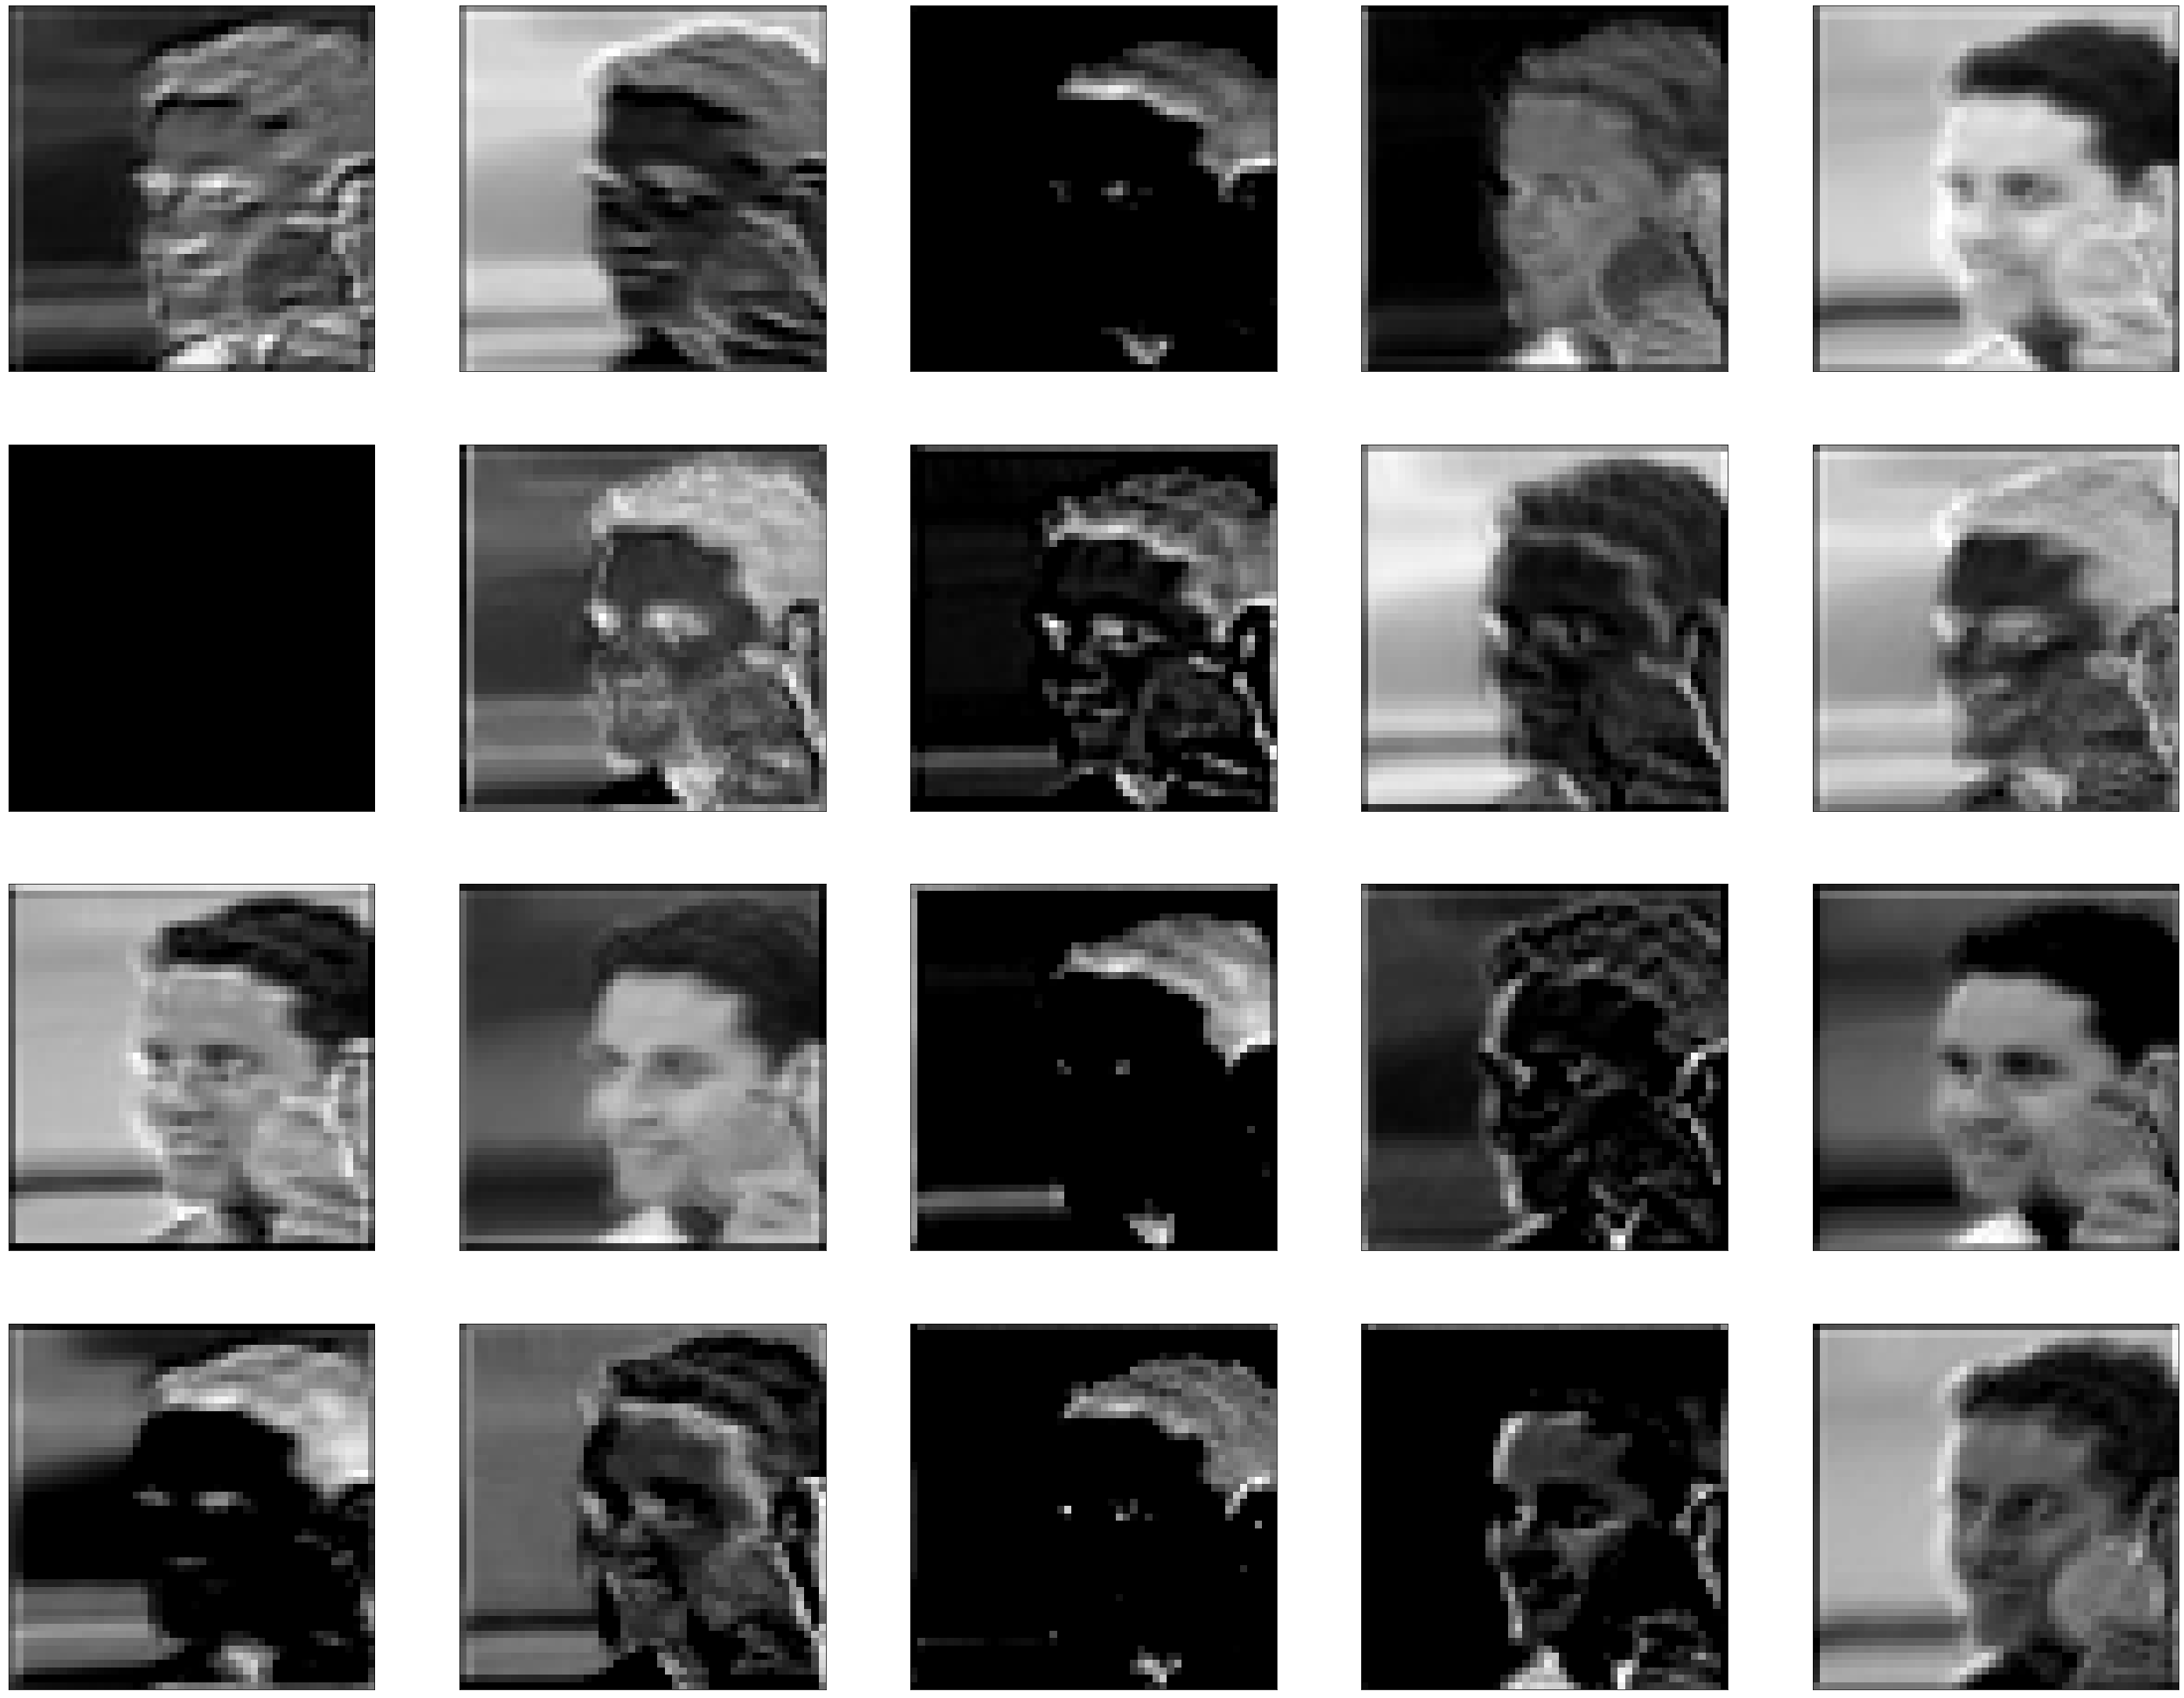

In [26]:
saved_model_path = "saved_models/40layers_auto_2.h5"
model = keras.models.load_model(saved_model_path)
new_model = keras.models.Sequential()
for layer in model.layers[:-8]: # just exclude the last 8 FC layers
    layer.trainable = False
    new_model.add(layer)
# new_model.summary()
decoded_imgs = new_model.predict(X_test)
graph_encoded_layer(1)

In [29]:
def graph_encoded_layer(num):
    for k in range(num):
        plt.figure(figsize=(25, 50))
        for i in range(40):
            ax = plt.subplot(10, 4, i+1)
            plt.imshow(decoded_imgs[k,:,:,i])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

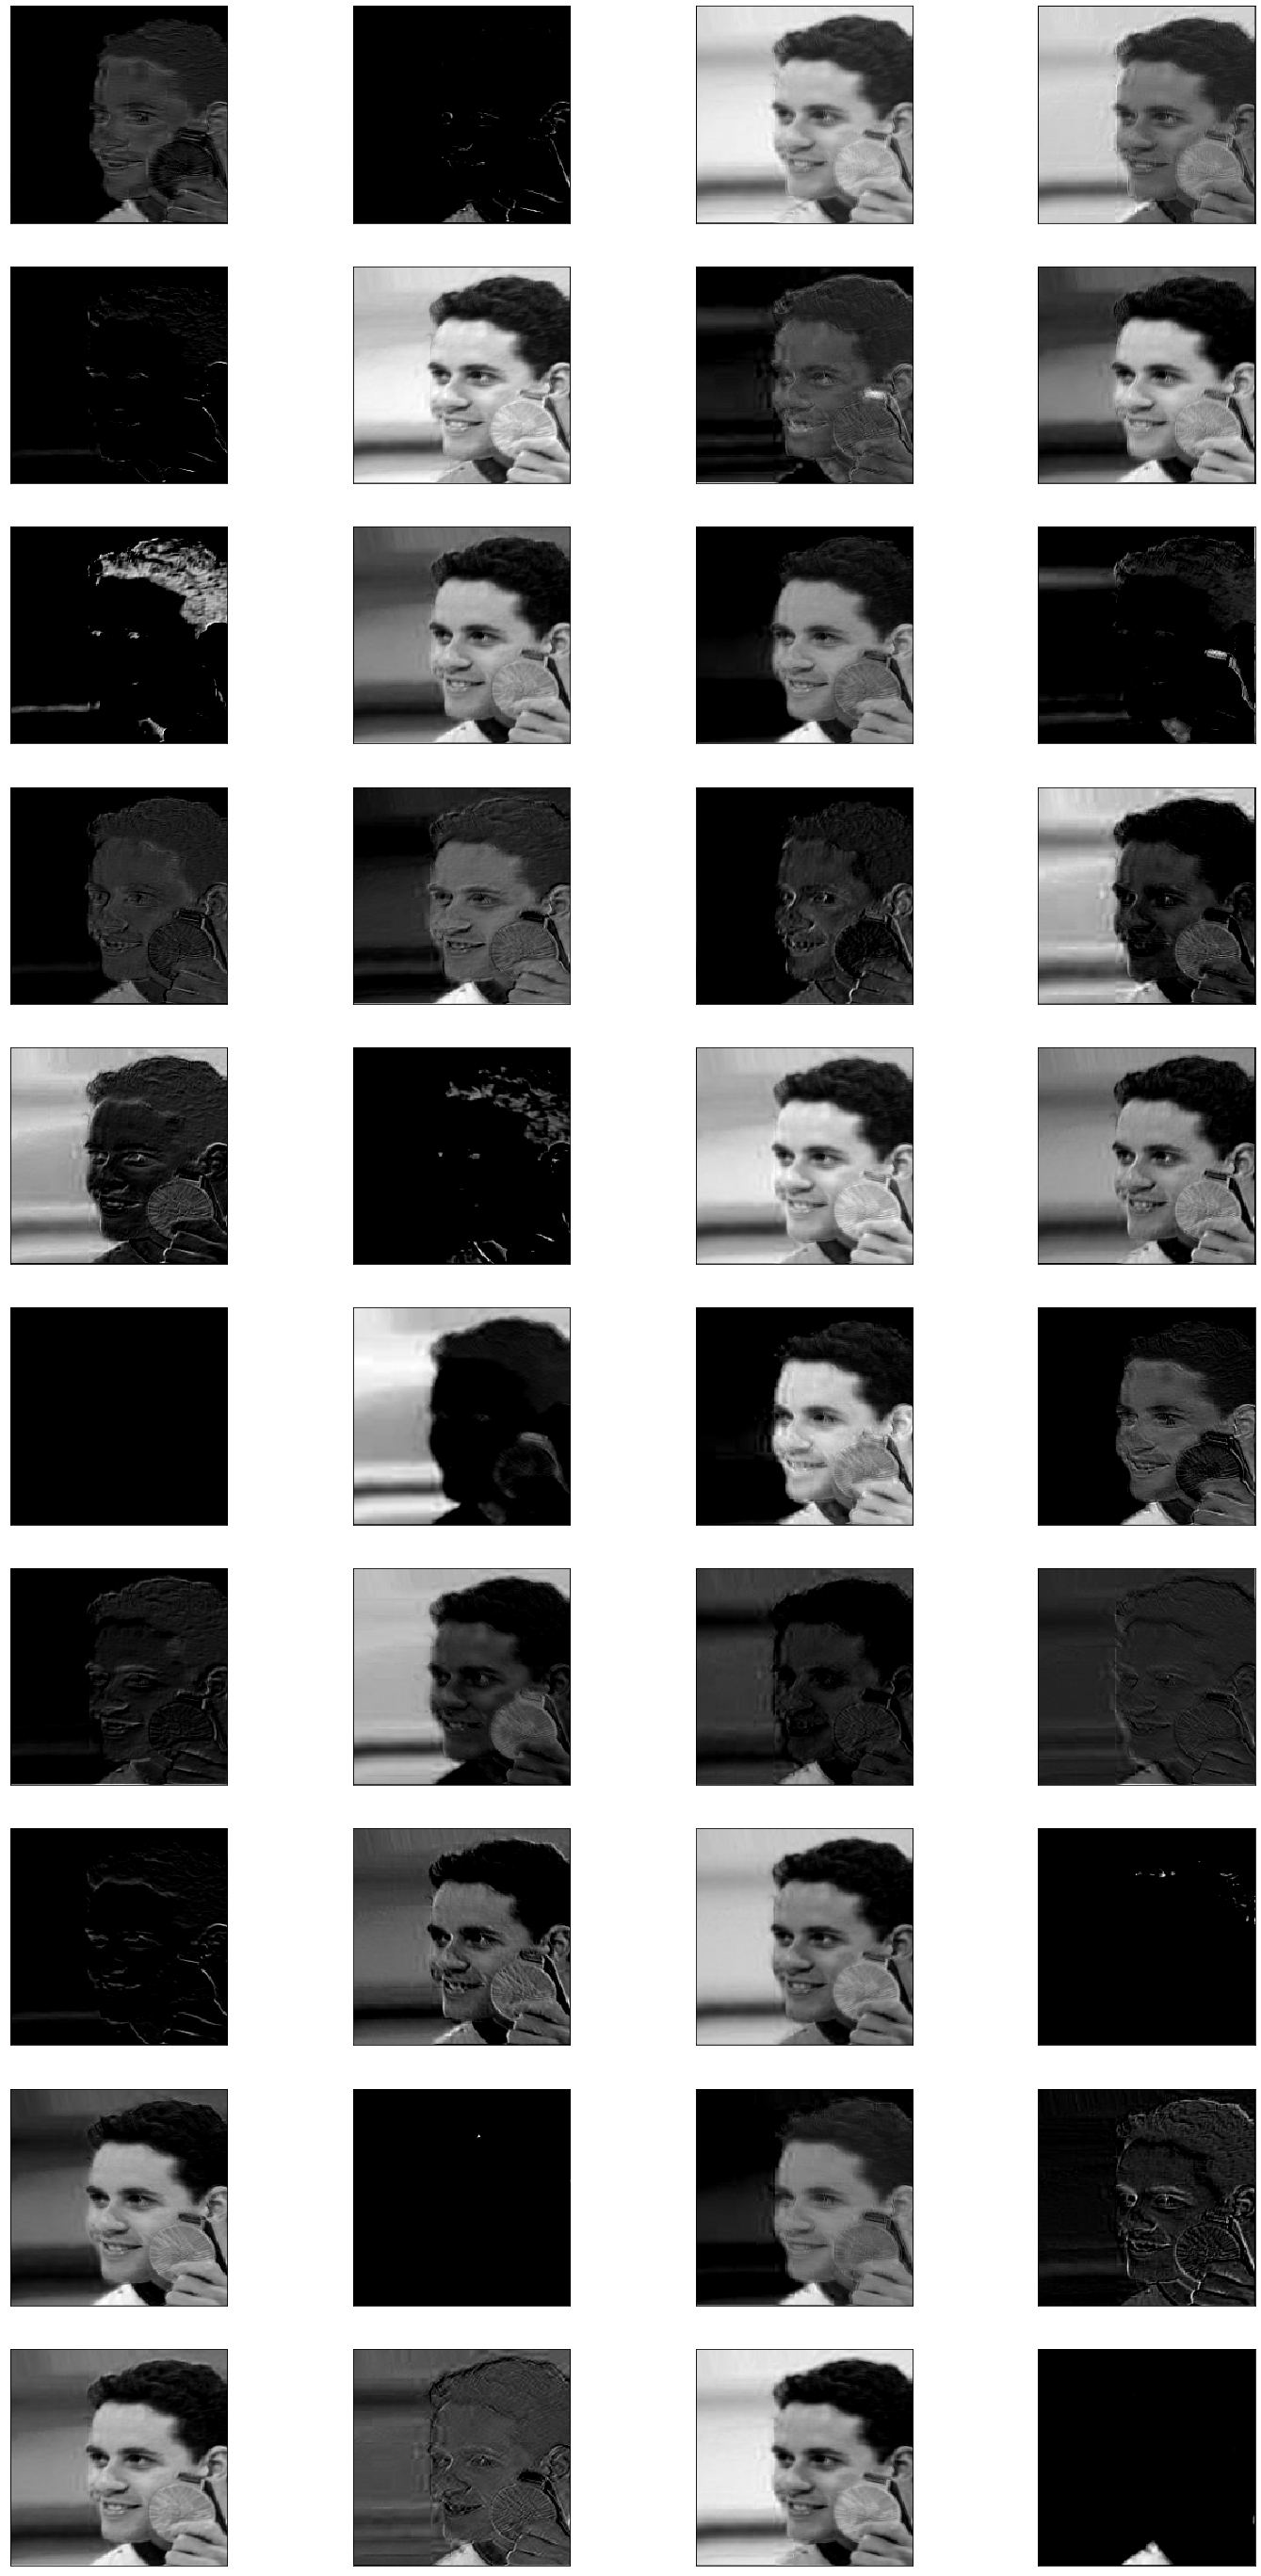

In [30]:
saved_model_path = "saved_models/40layers_auto_2.h5"
model = keras.models.load_model(saved_model_path)
new_model = keras.models.Sequential()
for layer in model.layers[:-12]: # just exclude the last 10 FC layers
    layer.trainable = False
    new_model.add(layer)
# new_model.summary()
decoded_imgs = new_model.predict(X_test)
graph_encoded_layer(1)

### Extracting features based on bottleneck layer

In [279]:
def feature_impt(mod):
    model = mod(verbose=1)
    model.fit(X_train, y_train)
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=20)
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    feat_scores.plot(kind='barh', figsize = (12,8))
    plt.title('Important Features to Determine Attraction')
#     plt.ylim(29,38);
    return model.score(X_test, y_test)

def run_it():
    model_list = [RandomForestClassifier, GradientBoostingClassifier]
    for i in model_list:
        print (feature_impt(i))

In [45]:
temp = X_train
temp_test = X_test

In [293]:
X_train = temp
X_test = temp_test

In [294]:
new_train = new_model.predict(X_train)
new_test = new_model.predict(X_test)

In [195]:
new_train[0,:,:,0].shape

(25, 25)

In [ ]:
train_train=[]
for i in range(1):
    for j in range(20):
        train_train.append(new_train[i,:,:,j].flatten())
        
test_test=[]
for i in range(1):
    for j in range(20):
        test_test.append(new_test[i,:,:,j].flatten())

In [306]:
# Flattens everything
X_train = new_train.reshape((-1, np.prod(new_train.shape[1:])))
X_test = new_test.reshape((-1, np.prod(new_test.shape[1:])))

In [284]:
y_train.shape

(1500,)

In [266]:
X_train.shape

(1500, 12500)

In [272]:
X_train.shape[1]

12500

In [289]:
run_it()

ValueError: setting an array element with a sequence.

In [304]:
x = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
# 10 clusters
n_clusters = 20
# Runs in parallel 4 CPUs
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(x)
# Evaluate the K-Means clustering accuracy.
metrics.acc(y, y_pred_kmeans)

ValueError: Found array with dim 4. Estimator expected <= 2.

## SVD on the Encoded Layer

In [310]:
import numpy as np
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
from sklearn.ensemble import RandomForestClassifier

In [307]:
X_train.shape

(1500, 12500)

In [315]:
U, s, V = np.linalg.svd(X_train)